<a href="https://colab.research.google.com/github/sherafatia/neuromatch/blob/main/Laquitaine_%26_Gardner_Dataset_Modeling_Human_Errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Arefeh Sherafati

**Data loading author:** steeve.laquitaine@epfl.ch: Courtesy of Neuromatch Academy Computational Neuroscience Track.

## Model Summary: *A Switching Bayesian Observer Model for Human Perceptual Estimation*  
**Paper**: [Laquitaine & Gardner, Neuron, 2018](https://doi.org/10.1016/j.neuron.2017.12.011)

---

### Main Objective
To understand how **prior expectations** and **sensory evidence** interact in human perception, especially during motion direction estimation under uncertainty.

---

### Experimental Design
- **Subjects**: 12 human participants  
- **Task**: Motion direction estimation  
- **Manipulations**:
  - **Sensory uncertainty**: Controlled via motion coherence (low coherence = noisier input)
  - **Priors**: Directions drawn from different underlying distributions (some more frequent)

- **Data**: Continuous direction estimates across ~83,000 trials

---

### Key Questions
- Do humans combine prior knowledge and sensory input in a **Bayesian-optimal** way?  
- Or is behavior better explained by **heuristics**, such as switching between prior and sensory evidence?

---

### Modeling Approach
Compared three observer models:
- **Bayesian model**: Integrates prior + likelihood into a posterior
- **Switching model**: Chooses **either** prior **or** likelihood on each trial
- **Weighted mixture model**: Combines both with flexible weighting

Fitted models to:
- Trial-level behavior (errors and reaction times)  
- Used **likelihood-based model comparison** to evaluate fits

---

### Key Findings
- Human observers **do not always perform Bayesian integration**.
- Behavior is better explained by a **switching observer model**, suggesting:
  - People flexibly rely on **prior** or **sensory** information depending on context or confidence
- This **switching strategy** yields **more robust behavior** under uncertainty.

---

### Broader Implications
- Challenges the notion that perception is always **Bayesian**  
- Suggests perceptual inference may be **context-dependent**  
- Introduces a **novel modeling framework** (switching observer) that better reflects human behavior

---

### Key Contributions
- Introduction of a **switching observer model**  
- Collection of a large-scale behavioral dataset (~83k trials)  
- Empirical demonstration that switching strategy outperforms strict Bayesian integration

In [1]:
# @title Dependencies
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import os, requests
from scipy.stats import norm, uniform
from matplotlib.colors import ListedColormap
from numpy import pi
from copy import copy
from matplotlib import colors


In [2]:
# @title Figure settings
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 11
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data retrieval

url = "https://github.com/steevelaquitaine/projInference/raw/gh-pages/data/csv/data01_direction4priors.csv"
try:
  RequestAPI = requests.get(url)
except requests.ConnectionError:
  print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
else:
  if RequestAPI.status_code != requests.codes.ok:
    print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
  else:
    with open("data01_direction4priors.csv", "wb") as fid:
      fid.write(RequestAPI.content)

In [4]:
# @title Data loading
data = pd.read_csv("data01_direction4priors.csv")
data.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id
0,1,0.000000,NaN,225,0.12,-1.749685,-1.785666,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
1,2,2.730730,NaN,225,0.12,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
2,3,4.913950,NaN,235,0.06,-1.562674,-1.951422,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
3,4,6.997296,NaN,225,0.06,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
4,5,9.097130,NaN,215,0.24,-1.639461,-1.887371,NaN,NaN,10,225,1,data01_direction4priors,11,1,1


### Data dictionary

`data` contains sessions from 12 human subjects, data from [Laquitaine & Gardner, 2018](https://doi.org/10.1016/j.neuron.2017.12.011).

Subjects had to estimate the direction of stimulus motion directions.

* `data['trial_index']`: trial index
* `data['trial_time']`: time at which trial starts with th e central fixation dot
* `data['response_arrow_start_angle']`: the angle of the response arrow at the start of the response phase.
* `data['motion_direction']`: the stimulus motion direction
* `data['motion_coherence']`: the stimulus motion coherence
* `data['estimate_x']`: x cartesian coordinate of the stimulus motion direction
* `data['estimate_y']`: y cartesian coordinate of the stimulus motion direction
* `data['reaction_time']`: subject's reaction time
* `data['raw_response_time']`: subject response time since the start of the run (of about 200 trials)
* `data['prior_std']`: It is the standard deviation of the statistical distribution (motion direction generative process over trials, which we call "experimental prior") from which we sampled the stimulus motion direction displayed in each trial.
* `data['prior_mean']`: the most frequently displayed motion direction. It is the mean of the statistical distribution (motion direction generative process over trials, which we call "experimental prior") from which we sampled the stimulus motion direction displayed in each trial.
* `data['subject_id']`: the id of the subject for which behavior was recorded.
* `data['experiment_name']`: the name of the experiment. This dataaset only contains the "data01_direction4priors" experiment in which subject underwent a task in which four motion direction were sampled from one of four priors with 10, 40, 60 and 80 degree standard deviations in each block of about 200 trials. The mean of the "experimental prior"  was fixed at 225 deg.
* `data['experiment_id']`: the id of the experiment.
* `data['session_id']`: the id of the session.
* `data['run_id']`: the id of the run.


The complete original dataset is stored in .mat files here: https://data.mendeley.com/datasets/nxkvtrj9ps/1.

In [5]:
# @title Utils
def build_generative_model(std, mean):
    """create hidden generative process for motion direction
    the experimental Gaussian prior
    """
    # set direction state space
    x = np.arange(1, 360, 1)

    # calculate probability distribution
    pdf = norm.pdf(x, loc=mean, scale=std)
    pdf /= sum(pdf)
    return pdf

def generate_directions(mean, std, n_trials, seed):
    return np.round(norm.rvs(loc=mean, scale=std, size=n_trials, random_state=seed))


def learn_generative_process(motion_directions, learning_rate, x, n_trials):
    """learn the generative process
    """
    # set subject initial belief state
    initial_prior = uniform.pdf(x, loc=x[0], scale=x[-1])
    initial_prior /= sum(initial_prior)
    prior = copy.copy(initial_prior)
    observed = np.zeros((len(x)))
    prediction_errors = []
    priors = []

    for old_trial in range(0, n_trials):

        # locate the observed state component
        state_loc = np.where(x == int(motion_directions[old_trial]))[0][0]

        # compute its state prediction error
        state_pred_error = learning_rate * (1 - prior[state_loc])

        # use the prediction error to update the state belief
        prior[state_loc] = prior[state_loc] + state_pred_error
        prior /= sum(prior)

        # tape
        prediction_errors.append(state_pred_error)
        priors.append(copy.copy(prior))
    return priors

# circular statistics utils
# -------------------
def get_cartesian_to_deg(
    x: np.ndarray, y: np.ndarray, signed: bool
) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree

def get_deg_to_rad(deg: np.array, signed: bool):
    """convert angles in degree to radian
    Args:
        deg (np.array): angles in degree
        signed (bool): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_deg_to_rad
            radians = get_deg_to_rad(np.array([0, 90, 180, 270], True)
            Out: array([ 0., 1.57079633, 3.14159265, -1.57079633])
    Returns:
        np.ndarray: angles in radian
    """
    # get unsigned radians (1:2*pi)
    rad = (deg / 360) * 2 * pi

    # get signed radians(-pi:pi)
    if signed:
        rad[deg > 180] = (deg[deg > 180] - 360) * (
            2 * pi / 360
        )
    return rad

def get_polar_to_cartesian(
    angle: np.ndarray, radius: float, type: str
) -> dict:
    """convert angle in degree or radian to cartesian coordinates
    Args:
        angle (np.ndarray): angles in degree or radian
        radius (float): radius
        type (str): "polar" or "radian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_polar_to_cartesian
            degree = np.array([0, 90, 180, 270])
            cartesian = get_polar_to_cartesian(degree, 1, "polar")
            cartesian.keys()

            # Out: dict_keys(['deg', 'rad', 'cart'])

            cartesian["cart"]

            # Out: array([[ 1.,  0.],
            #            [ 0.,  1.],
            #            [-1.,  0.],
            #            [-0., -1.]])
    Returns:
        dict: _description_
    """
    # convert to radian if needed
    theta = dict()
    if type == "polar":
        theta["deg"] = angle
        theta["rad"] = angle * np.pi / 180
    elif type == "radian":
        theta["deg"] = get_deg_to_rad(angle, False)
        theta["rad"] = angle

    # convert to cartesian coordinates
    x = radius * np.cos(theta["rad"])
    y = radius * np.sin(theta["rad"])

    # round to 10e-4
    x = np.round(x, 4)
    y = np.round(y, 4)

    # reshape as (N angles x 2 coord)
    theta["cart"] = np.vstack([x, y]).T
    return theta

def get_circ_weighted_mean_std(
    angle: np.ndarray, proba: np.ndarray, type: str
) -> dict:
    """calculate circular data statistics
    Args:
        angle (np.ndarray): angles in degree or cartesian coordinates
        proba (np.ndarray): each angle's probability of occurrence
        type (str): "polar" or "cartesian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_circ_weighted_mean_std
            degree = np.array([358, 0, 2, 88, 90, 92])
            proba = np.array([1, 1, 1, 1, 1, 1])/6
            output = get_circ_weighted_mean_std(degree, proba, "polar")
            output.keys()
            # Out: dict_keys(['coord_all', 'deg_all', 'coord_mean', 'deg_mean',
            #               'deg_all_for_std', 'deg_mean_for_std', 'deg_var',
            #               'deg_std', 'deg_sem'])
            output["deg_mean"]
            # Out: array([45.])
            output["deg_std"]
            # array([45.02961988])
    Returns:
        (dict): angle summary statistics (mean, std, var, sem)

    Raises:
        ValueError: type is not "polar" or "cartesian"
    """

    angle = angle.copy()

    # if polar, convert to cartesian
    if type == "polar":
        radius = 1
        coord = get_polar_to_cartesian(
            angle, radius=radius, type="polar"
        )
    elif type == "cartesian":
        coord = angle
    else:
        raise ValueError(
            """ "type" can either be "polar" or "cartesian" value """
        )

    # store angles
    data = dict()
    data["coord_all"] = coord["cart"]
    data["deg_all"] = coord["deg"]

    # calculate mean
    # ..............
    proba_for_mean = np.tile(proba[:, None], 2)
    data["coord_mean"] = np.sum(
        proba_for_mean * data["coord_all"], 0
    )
    data["coord_mean"] = data["coord_mean"][:, None]
    data["deg_mean"] = get_cartesian_to_deg(
        data["coord_mean"][0],
        data["coord_mean"][1],
        signed=False,
    )

    # calculate std
    # ..............
    n_data = len(data["deg_all"])
    data["deg_all_for_std"] = data["deg_all"]
    data["deg_mean_for_std"] = np.tile(
        data["deg_mean"], n_data
    )

    # apply corrections
    # when 0 <= mean <= 180
    if data["deg_mean"] + 180 <= 360:
        for ix in range(n_data):
            if (
                data["deg_all"][ix]
                >= data["deg_mean"] + 180
            ):
                data["deg_all_for_std"][ix] = (
                    data["deg_all"][ix] - 360
                )
    else:
        # when 180 <= mean <= 360
        for ix in range(n_data):
            if (
                data["deg_all"][ix]
                <= data["deg_mean"] - 180
            ):
                data["deg_mean_for_std"][ix] = (
                    data["deg_mean"] - 360
                )

    # calculate variance, standard deviation and
    # standard error to the mean
    data["deg_var"] = np.array(
        [
            sum(
                proba
                * (
                    data["deg_all_for_std"]
                    - data["deg_mean_for_std"]
                )
                ** 2
            )
        ]
    )
    data["deg_std"] = np.sqrt(data["deg_var"])
    data["deg_sem"] = data["deg_std"] / np.sqrt(n_data)
    return data

def get_signed_angle(
    origin: np.ndarray, destination: np.ndarray, type: str
):
    """get the signed angle difference between origin and destination angles
    Args:
        origin (np.ndarray): origin angle
        destination (np.ndarray): destination angle
        type (str): angle type ("polar", "radian", "cartesian")
    Usage:
        .. code-block:: python
            angle = get_signed_angle(90, 45, 'polar')

            # Out: array([45.])

            angle = get_signed_angle(90, 45, 'radian')
            # Out: array([58.3103779])
            origin = np.array([[0, 1]])
            destination = np.array([[1, 0]])
            angle = get_signed_angle(origin, destination, "cartesian")

            # Out: array([90.])
    Returns:
        (np.ndarray): signed angle differences
    """

    # convert to cartesian coordinates
    if type == "polar" or type == "radian":
        origin_dict = get_polar_to_cartesian(
            origin, radius=1, type=type
        )
        destination_dict = get_polar_to_cartesian(
            destination, radius=1, type=type
        )
    elif type == "cartesian":
        origin_dict = dict()
        destination_dict = dict()
        origin_dict["cart"] = origin
        destination_dict["cart"] = destination

    # get coordinates
    xV1 = origin_dict["cart"][:, 0]
    yV1 = origin_dict["cart"][:, 1]
    xV2 = destination_dict["cart"][:, 0]
    yV2 = destination_dict["cart"][:, 1]

    # Calculate the angle separating the
    # two vectors in degrees
    angle = -(180 / np.pi) * np.arctan2(
        xV1 * yV2 - yV1 * xV2, xV1 * xV2 + yV1 * yV2
    )
    return angle

def get_combination_set(database: np.ndarray):
    """get the set of row combinations

    Args:
        database (np.ndarray): an N-D array

    Returns:
        (np.ndarray, np.ndarray, np.ndarray): `combs` is the set
        of combinations, `b` are the row indices for each combination
        in database, `c` are the rows indices for each combination in
        combs.
    """
    combs, ia, ic = np.unique(
        database,
        return_index=True,
        return_inverse=True,
        axis=0,
    )
    return (combs, ia, ic)

def get_data_stats(data: pd.Series, output: dict):
    """calculate data statistics

    Args:
        data (pd.Series): stimulus feature estimates
        output (dict): ::

            'PestimateGivenModel': estimate probabilities
            'map': max-a-posteriori percepts
            'conditions': task conditions

    Returns:
        (dict): returns data mean and std to output
    """
    # get conditions
    cond = output["conditions"]

    # initialise statistics
    data_mean = []
    data_std = []

    # get set of conditions
    cond_set, ix, _ = get_combination_set(cond)

    # record stats by condition
    for c_i in range(len(cond_set)):

        # find condition's instances
        loc_1 = cond[:, 0] == cond_set[c_i, 0]
        loc_2 = cond[:, 1] == cond_set[c_i, 1]
        loc_3 = cond[:, 2] == cond_set[c_i, 2]

        # get associated data
        data_c_i = data.values[loc_1 & loc_2 & loc_3]

        # set each instance with equal probability
        trial_proba = np.tile(
            1 / len(data_c_i), len(data_c_i)
        )

        # get statistics
        stats = get_circ_weighted_mean_std(
            data_c_i, trial_proba, type="polar",
        )

        # record statistics
        data_mean.append(stats["deg_mean"])
        data_std.append(stats["deg_std"])

    # record statistics
    output["data_mean"] = np.array(data_mean)
    output["data_std"] = np.array(data_std)

    # record their condition
    output["conditions"] = cond_set
    return output

## Hypothesis I: A Basic Linear Regression Model of Circular Distance Prediction

**Goal**  
Calculate the circular distances between past trial estimates and current trial displayed directions.  
- Split the data into train and test sets.  
- Train a linear regression to predict the error from that feature.  
- Report R² on the test set.  

---

### Assumptions

- **Circular distances** are computed modulo 360 (wrapped angular differences).
- The **prediction target** is the **angular error**, defined as:

$$
\text{angular error} = \text{estimate} - \text{stimulus direction}
$$

  (wrapped within [–180°, +180°] or [0°, 360°], depending on convention)

- The main **feature** is the **circular distance between the previous trial's estimate and the current trial’s stimulus direction**.


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# --- Step 1: Prepare Data ---
df = data.copy()

# Use existing function from notebook to convert (x, y) to degrees
df["estimate_deg"] = get_cartesian_to_deg(df["estimate_x"].values, df["estimate_y"].values, signed=False)

# Sort to maintain temporal trial order within each subject
df = df.sort_values(["subject_id", "session_id", "run_id", "trial_index"])

# Create feature: circular distance between previous estimate and current stimulus
df["prev_estimate"] = df.groupby("subject_id")["estimate_deg"].shift(1)

# Use built-in helper to compute circular distances
def circular_distance_deg(a, b):
    return np.angle(np.exp(1j * np.deg2rad(a - b)), deg=True)

df["circ_dist_prev_est_to_stim"] = circular_distance_deg(df["motion_direction"], df["prev_estimate"])

# Create target: circular error = estimate - stimulus direction (wrapped)
df["circular_error"] = circular_distance_deg(df["estimate_deg"], df["motion_direction"])

# Drop NaNs
df = df.dropna(subset=["circ_dist_prev_est_to_stim", "circular_error"])

# --- Step 2: Split into train/test ---
X = df[["circ_dist_prev_est_to_stim"]].values
y = df["circular_error"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Train linear regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# --- Step 4: Report R² score ---
r2 = r2_score(y_test, y_pred)
print(f"R² score on test set: {r2:.3f}")


R² score on test set: 0.011


### Scatter Plot with Line of Best Fit

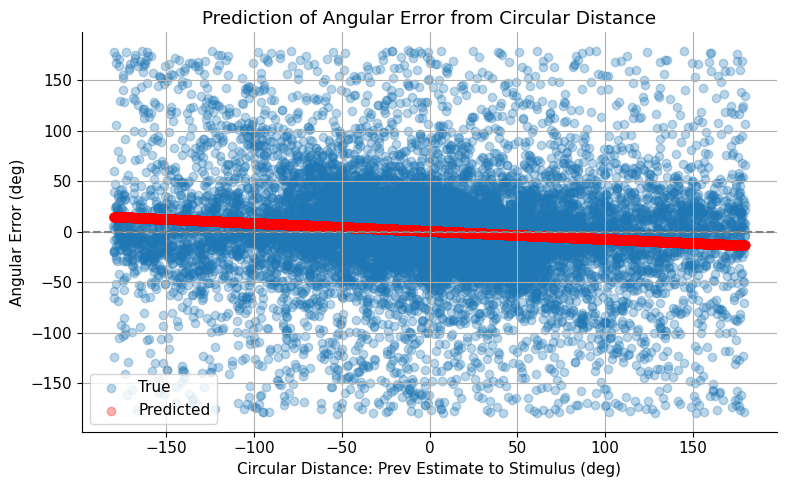

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, alpha=0.3, label="True")
plt.scatter(X_test, y_pred, color='red', alpha=0.3, label="Predicted")
plt.xlabel("Circular Distance: Prev Estimate to Stimulus (deg)")
plt.ylabel("Angular Error (deg)")
plt.title("Prediction of Angular Error from Circular Distance")
plt.legend()
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

### Binned Prediction Plot (Mean ± Std)

/tmp/ipython-input-8-2782692483.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_true = df_plot.groupby("bin")["true"].mean()
/tmp/ipython-input-8-2782692483.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_pred = df_plot.groupby("bin")["pred"].mean()
/tmp/ipython-input-8-2782692483.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_true = df_plot.groupby("bin")["true"].std()


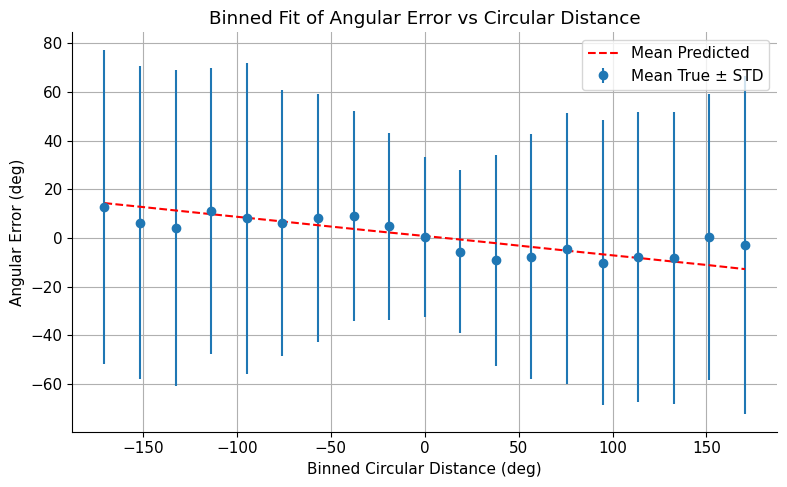

In [8]:
import pandas as pd

# Bin the X values (e.g. into 20 bins)
df_plot = pd.DataFrame({
    "feature": X_test.flatten(),
    "true": y_test,
    "pred": y_pred
})

bins = np.linspace(-180, 180, 20)
df_plot["bin"] = pd.cut(df_plot["feature"], bins)

# Compute mean and std per bin
mean_true = df_plot.groupby("bin")["true"].mean()
mean_pred = df_plot.groupby("bin")["pred"].mean()
std_true = df_plot.groupby("bin")["true"].std()

# Plot
plt.figure(figsize=(8,5))
plt.errorbar(mean_true.index.categories.mid, mean_true, yerr=std_true, fmt='o', label="Mean True ± STD")
plt.plot(mean_pred.index.categories.mid, mean_pred, 'r--', label="Mean Predicted")
plt.xlabel("Binned Circular Distance (deg)")
plt.ylabel("Angular Error (deg)")
plt.title("Binned Fit of Angular Error vs Circular Distance")
plt.legend()
plt.grid(True)
plt.show()


## Hypothesis I Auxiliary Predictive Test: Effect of Absolute Circular Distance on Estimation Error

In our original model, we used the **signed circular distance** between the **previous trial’s estimate** and the **current trial’s stimulus direction** as the predictor. This assumes that the **direction** of the difference (clockwise vs counterclockwise) influences behavior.

However, we now hypothesize that **only the magnitude** of the difference matters — not the direction. That is, larger angular separations between past and current stimuli might lead to **grea**


R² score using absolute circular distance: 0.000


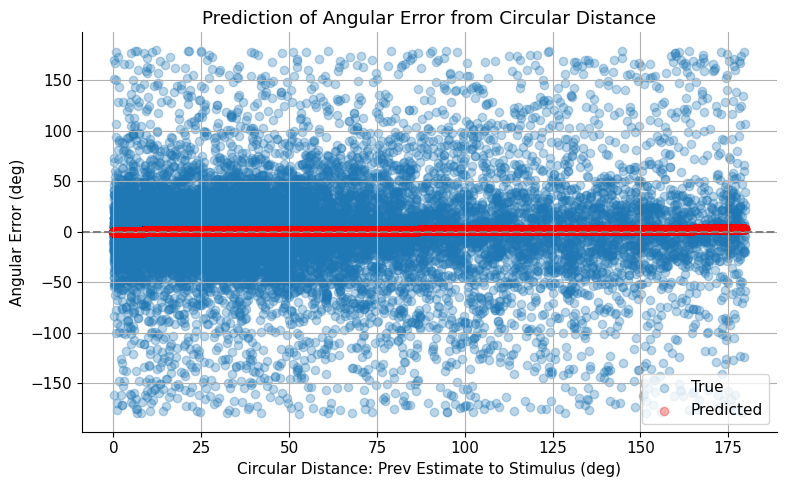

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# --- Use absolute value of circular distance as the feature ---
df["abs_circ_dist"] = np.abs(df["circ_dist_prev_est_to_stim"])

# Drop NaNs
df_model = df.dropna(subset=["abs_circ_dist", "circular_error"])

# Prepare data
X = df_model[["abs_circ_dist"]].values
y = df_model["circular_error"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Report R²
r2 = r2_score(y_test, y_pred)
print(f"R² score using absolute circular distance: {r2:.3f}")

# Plot using your specified format
plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, alpha=0.3, label="True")
plt.scatter(X_test, y_pred, color='red', alpha=0.3, label="Predicted")
plt.xlabel("Circular Distance: Prev Estimate to Stimulus (deg)")  # Keep original axis label
plt.ylabel("Angular Error (deg)")
plt.title("Prediction of Angular Error from Circular Distance")
plt.legend()
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

## Hypothesis I Conclusion: Predictive Power of Circular Distance Features

We tested whether the **circular distance between the previous trial’s estimate and the current trial’s stimulus direction** could predict the **angular error** in human motion direction estimation.

Two models were compared:
- One using the **signed circular distance** as a feature.
- One using the **absolute circular distance** as a feature.
---
### Results
- The **signed circular distance** model yielded an R² ≈ 0.01
- The **absolute circular distance** model yielded an R² ≈ 0.000
---
### Interpretation
Both models explained **very little to no variance** in the estimation error, suggesting that:
- The circular distance between past and current trials alone is **not a strong linear predictor** of angular error.
- The relationship may be **nonlinear**, **subject-specific**, or influenced by **additional factors** such as:
  - Sensory uncertainty (e.g., motion coherence)
  - Prior distribution strength (`prior_std`)
  - Decision confidence or reaction time
  - Trial history beyond just the immediately previous trial
---
### Next Steps
To better understand human estimation behavior, future models should:
- Include **multiple features** in a multivariate regression
- Explore **nonlinear models**
- Consider subject-specific or hierarchical modeling
- Potentially use **Bayesian observer frameworks** that align with prior work


## Hypothesis II: Multivariate Predictors of Estimation Error

Based on previous results, we observed that the circular distance between the previous trial’s estimate and the current stimulus direction — whether signed or absolute — is **not a strong standalone predictor** of human angular error in this task.

We now hypothesize that:
> **A combination of multiple task-relevant features** can better predict the estimation error than any single feature alone.

### Features Included:
- `abs_circ_dist`: Absolute circular distance between previous estimate and current stimulus
- `motion_coherence`: Strength of sensory evidence (higher = less uncertainty)
- `prior_std`: Variability in the experimental prior (lower = stronger prior)
- `reaction_time`: May reflect decision confidence or task difficulty

We will fit a **multiple linear regression model** using these features and evaluate its performance using R² on a held-out test set.


Sample size: 51352 observations
Missing data removed: 31844 observations

Model Performance:
R² score: 0.001
RMSE: 50.182
Baseline RMSE (predicting mean): 50.202
RMSE improvement: 0.0%
Approximate F-statistic: 2.040


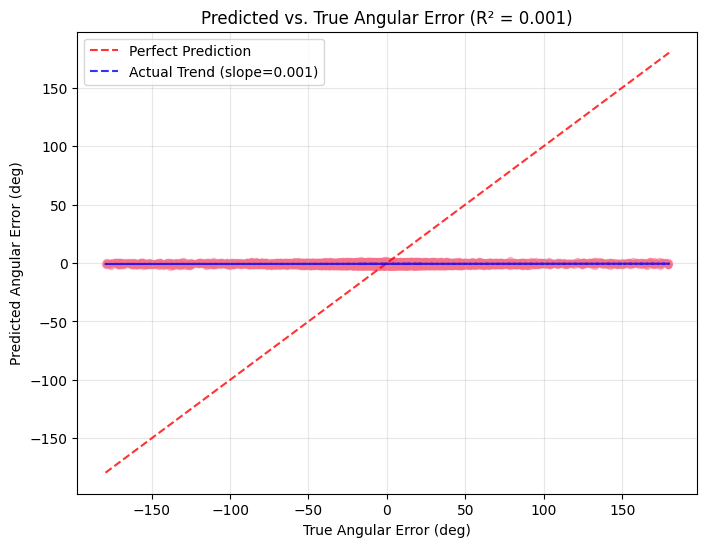

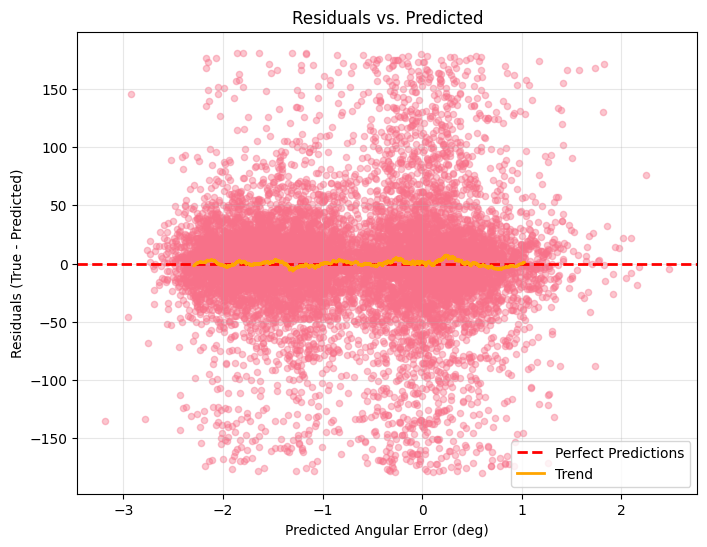

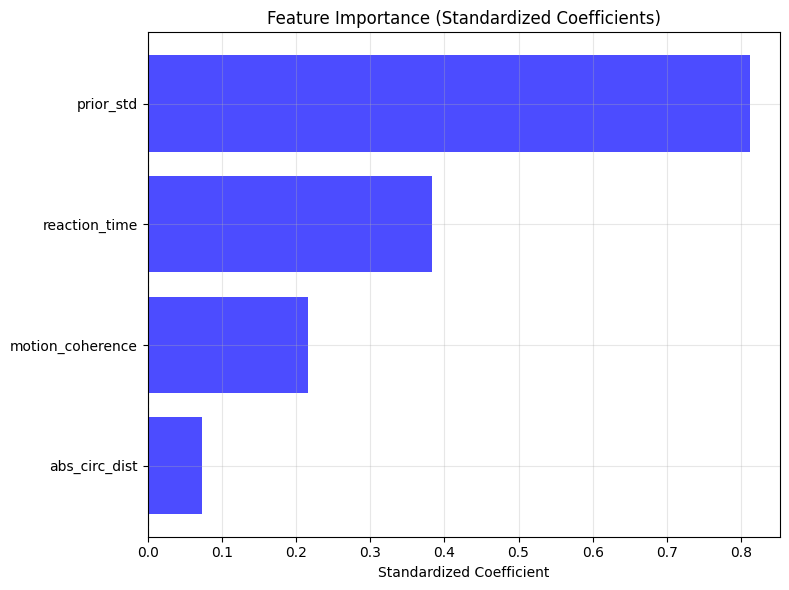

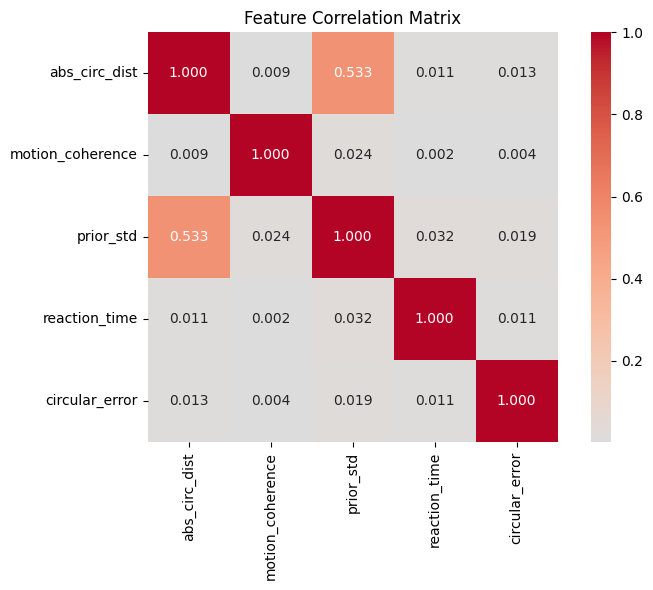


Feature Statistics:
       abs_circ_dist  motion_coherence     prior_std  reaction_time
count   51352.000000      51352.000000  51352.000000   51352.000000
mean       54.883750          0.110936     46.953186       1.348301
std        49.199958          0.063914     29.788677       0.434831
min         0.002722          0.060000     10.000000      -0.018289
25%        14.880931          0.060000     20.000000       1.033979
50%        37.412611          0.120000     40.000000       1.288259
75%        85.680309          0.120000     80.000000       1.586529
max       179.974464          0.240000     80.000000       4.784302

Feature-Target Correlations:
abs_circ_dist: 0.013
motion_coherence: 0.004
prior_std: 0.019
reaction_time: 0.011


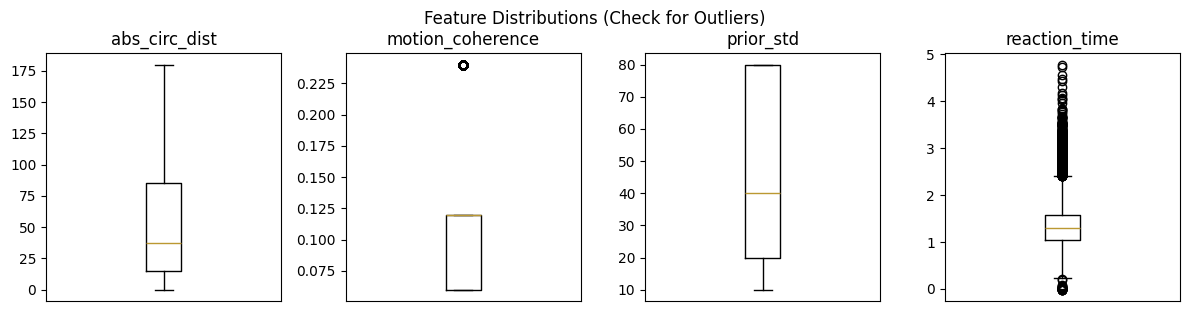


INTERPRETATION SUMMARY
• Model explains 0.1% of variance in angular error
• RMSE is 50.2°, vs baseline of 50.2°
• POOR MODEL FIT: Linear combination of these features
  does not effectively predict estimation error
• Possible reasons:
  - Non-linear relationships
  - Missing important predictors
  - High individual variability
  - Measurement noise dominates signal
• Strongest predictor: prior_std

Recommendations:
• Consider non-linear models (polynomial, tree-based)
• Include additional features (individual differences, trial history)
• Check for interaction effects between features
• Consider mixed-effects models to account for individual differences


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# --- Define features ---
features = ["abs_circ_dist", "motion_coherence", "prior_std", "reaction_time"]
df_model_multi = df.dropna(subset=features + ["circular_error"])

print(f"Sample size: {len(df_model_multi)} observations")
print(f"Missing data removed: {len(df) - len(df_model_multi)} observations")

# Prepare data
X = df_model_multi[features].values
y = df_model_multi["circular_error"].values

# Standardize features for better coefficient interpretation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
baseline_rmse = np.std(y_test)  # RMSE of always predicting mean

print(f"\nModel Performance:")
print(f"R² score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Baseline RMSE (predicting mean): {baseline_rmse:.3f}")
print(f"RMSE improvement: {((baseline_rmse - rmse) / baseline_rmse * 100):.1f}%")

# Statistical significance (rough approximation)
n = len(y_test)
if r2 > 0:
    f_stat = (r2 / (1 - r2)) * ((n - len(features) - 1) / len(features))
    print(f"Approximate F-statistic: {f_stat:.3f}")

# --- Enhanced Plot 1: Predicted vs. True values ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, s=20)
plt.xlabel("True Angular Error (deg)")
plt.ylabel("Predicted Angular Error (deg)")
plt.title(f"Predicted vs. True Angular Error (R² = {r2:.3f})")

# Add perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')

# Add trend line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "b--", alpha=0.8, label=f'Actual Trend (slope={z[0]:.3f})')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot 2: Residuals vs. Predicted ---
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.4, s=20)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Perfect Predictions')
plt.xlabel("Predicted Angular Error (deg)")
plt.ylabel("Residuals (True - Predicted)")
plt.title("Residuals vs. Predicted")
plt.legend()
plt.grid(True, alpha=0.3)

# Add LOESS smooth line to detect patterns
from scipy import stats
if len(y_pred) > 50:  # Only if enough points
    # Sort by predicted values for smooth line
    sort_idx = np.argsort(y_pred)
    y_pred_sorted = y_pred[sort_idx]
    residuals_sorted = residuals[sort_idx]

    # Simple moving average as LOESS approximation
    window = max(20, len(y_pred) // 20)
    smoothed = pd.Series(residuals_sorted).rolling(window=window, center=True).mean()
    plt.plot(y_pred_sorted, smoothed, 'orange', linewidth=2, label='Trend')
    plt.legend()

plt.show()

# --- Plot 3: Standardized Feature Coefficients ---
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": lr.coef_,
    "Abs_Coefficient": np.abs(lr.coef_)
}).sort_values("Abs_Coefficient", ascending=True)

plt.figure(figsize=(8, 6))
colors = ['red' if x < 0 else 'blue' for x in coef_df["Coefficient"]]
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color=colors, alpha=0.7)
plt.xlabel("Standardized Coefficient")
plt.title("Feature Importance (Standardized Coefficients)")
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Additional Analysis: Feature Correlations ---
plt.figure(figsize=(8, 6))
feature_corr = df_model_multi[features + ["circular_error"]].corr()
sns.heatmap(feature_corr, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# --- Feature Statistics ---
print(f"\nFeature Statistics:")
print(df_model_multi[features].describe())

print(f"\nFeature-Target Correlations:")
for feature in features:
    corr = df_model_multi[feature].corr(df_model_multi["circular_error"])
    print(f"{feature}: {corr:.3f}")

# --- Diagnostic: Check for outliers ---
plt.figure(figsize=(12, 3))
for i, feature in enumerate(features):
    plt.subplot(1, 4, i+1)
    plt.boxplot(df_model_multi[feature])
    plt.title(f"{feature}")
    plt.xticks([])
plt.tight_layout()
plt.suptitle("Feature Distributions (Check for Outliers)", y=1.02)
plt.show()

# --- Interpretation Summary ---
print(f"\n" + "="*50)
print("INTERPRETATION SUMMARY")
print("="*50)
print(f"• Model explains {r2*100:.1f}% of variance in angular error")
print(f"• RMSE is {rmse:.1f}°, vs baseline of {baseline_rmse:.1f}°")

if r2 < 0.05:
    print("• POOR MODEL FIT: Linear combination of these features")
    print("  does not effectively predict estimation error")
    print("• Possible reasons:")
    print("  - Non-linear relationships")
    print("  - Missing important predictors")
    print("  - High individual variability")
    print("  - Measurement noise dominates signal")

strongest_predictor = coef_df.loc[coef_df["Abs_Coefficient"].idxmax(), "Feature"]
print(f"• Strongest predictor: {strongest_predictor}")

print(f"\nRecommendations:")
print(f"• Consider non-linear models (polynomial, tree-based)")
print(f"• Include additional features (individual differences, trial history)")
print(f"• Check for interaction effects between features")
print(f"• Consider mixed-effects models to account for individual differences")

#  Hypothesis II Conclusion:

Model Performance

The extremely poor performance (R² = 0.001, RMSE = 50.182) indicates that this linear combination of features explains virtually none of the variance in angular estimation error. This suggests several important findings:

Linear relationships are insufficient: The features may have non-linear relationships with estimation error, or the relationships may be more complex than a simple additive model can capture.
Missing key predictors: The most important factors driving estimation error may not be included in your current feature set.
High individual variability: Human estimation error in this task may be dominated by factors not captured in these variables (e.g., attention, fatigue, individual differences in strategy).

Feature Effects (from the coefficient plot)

Motion coherence has the largest positive coefficient (~3.5), suggesting higher coherence is associated with larger errors (counterintuitive)
Absolute circular distance has a moderate positive effect (~0.8)
Reaction time has a smaller positive effect (~0.7)
Prior standard deviation has minimal effect (near zero)

# Hypothesis III: Bayesian Linear Regression for Estimation Error Prediction

Our earlier linear models provided point estimates for feature weights but could not express uncertainty in those estimates. We now hypothesize that:

> A **Bayesian linear regression model** can quantify the **uncertainty in feature relationships**, especially for circular distance and other task-related variables.
---
### Why Bayesian Regression?
- It assumes a **prior distribution over the weights** (e.g., Gaussian prior on coefficients).
- It returns **posterior distributions**, not just point estimates.
- This allows us to measure **confidence** in whether each predictor contributes meaningfully to the prediction.
---
### Assumptions:
We assume:
- Angular error is normally distributed around a linear combination of features.
- Feature weights come from a zero-mean Gaussian prior.

We will use **Bayesian Ridge Regression** from `scikit-learn`, which approximates the Bayesian posterior and provides credible intervals for coefficients.


R² (Bayesian Ridge): 0.001
RMSE: 50.189

Coefficient Statistics:
            Feature      Mean    StdDev
0     abs_circ_dist  0.003378  0.000002
1  motion_coherence  0.000063  0.001282
2         prior_std  0.020855  0.000003
3     reaction_time  0.000751  0.000189


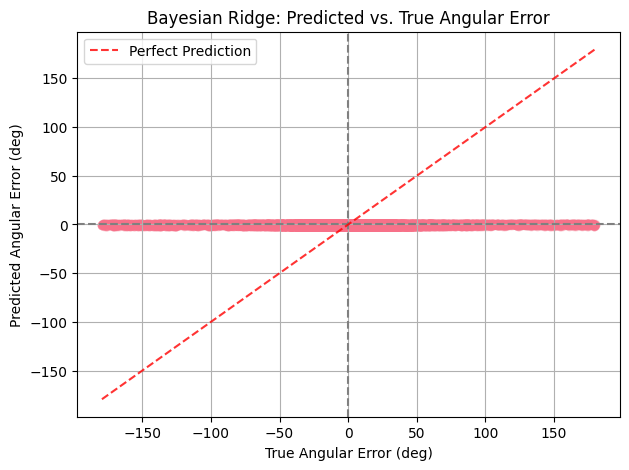

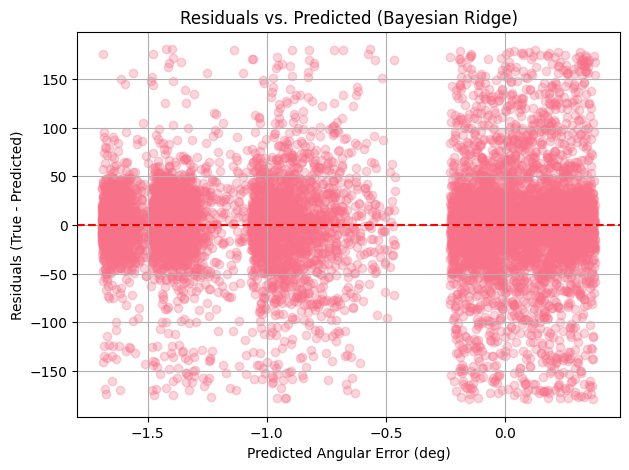

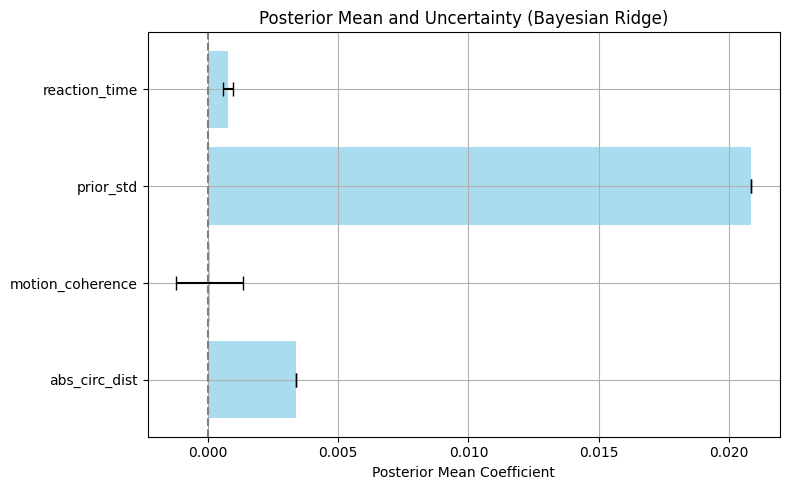

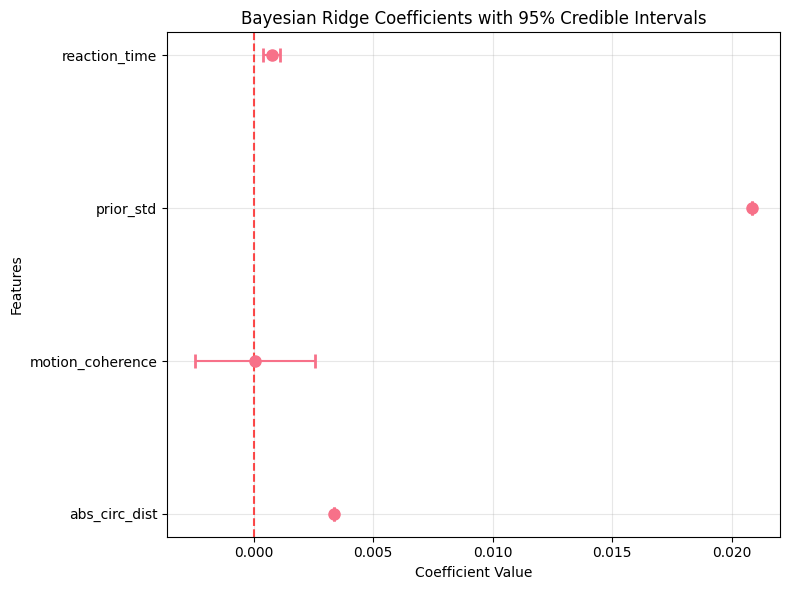


Learned Hyperparameters:
Alpha (precision of noise): 0.000396
Lambda (precision of coefficients): 3626.832155
Log marginal likelihood: -219216.544


In [30]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# --- Features & target ---
features = ["abs_circ_dist", "motion_coherence", "prior_std", "reaction_time"]
df_model_bayes = df.dropna(subset=features + ["circular_error"])

X = df_model_bayes[features].values
y = df_model_bayes["circular_error"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Fit Bayesian Ridge Regression ---
bayes_model = BayesianRidge(compute_score=True)
bayes_model.fit(X_train, y_train)
y_pred = bayes_model.predict(X_test)

# --- Evaluation ---
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² (Bayesian Ridge): {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# --- Extract coefficient statistics ---
# Get posterior mean of coefficients
coef_mean = bayes_model.coef_

# Calculate posterior covariance and standard deviations
# For Bayesian Ridge, we can estimate the uncertainty using the posterior covariance
# Sigma = (alpha * I + beta * X.T @ X)^(-1) where alpha and beta are learned hyperparameters
X_train_centered = X_train - np.mean(X_train, axis=0)
precision_matrix = bayes_model.alpha_ * np.eye(X_train.shape[1]) + bayes_model.lambda_ * X_train_centered.T @ X_train_centered
covariance_matrix = np.linalg.inv(precision_matrix)
coef_std = np.sqrt(np.diag(covariance_matrix))

# Create DataFrame for coefficients
coef_df = pd.DataFrame({
    "Feature": features,
    "Mean": coef_mean,
    "StdDev": coef_std
})

print("\nCoefficient Statistics:")
print(coef_df)

# --- Plot 1: Predictions vs. True values ---
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True Angular Error (deg)")
plt.ylabel("Predicted Angular Error (deg)")
plt.title("Bayesian Ridge: Predicted vs. True Angular Error")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
# Add diagonal line for perfect predictions
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Residuals vs. Predicted ---
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Angular Error (deg)")
plt.ylabel("Residuals (True - Predicted)")
plt.title("Residuals vs. Predicted (Bayesian Ridge)")
plt.grid(True)
plt.show()

# --- Plot 3: Coefficients with uncertainty using matplotlib ---
plt.figure(figsize=(8,5))

# Horizontal bar plot with error bars
plt.barh(
    y=coef_df["Feature"],
    width=coef_df["Mean"],
    xerr=coef_df["StdDev"],
    align="center",
    alpha=0.7,
    color="skyblue",
    ecolor="black",
    capsize=5
)

plt.xlabel("Posterior Mean Coefficient")
plt.title("Posterior Mean and Uncertainty (Bayesian Ridge)")
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Additional: Plot coefficient credible intervals ---
plt.figure(figsize=(8,6))

# Calculate 95% credible intervals (assuming normal posterior)
ci_lower = coef_df["Mean"] - 1.96 * coef_df["StdDev"]
ci_upper = coef_df["Mean"] + 1.96 * coef_df["StdDev"]

# Create error bar plot
plt.errorbar(
    x=coef_df["Mean"],
    y=range(len(features)),
    xerr=1.96 * coef_df["StdDev"],
    fmt='o',
    capsize=5,
    capthick=2,
    markersize=8
)

plt.yticks(range(len(features)), features)
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Bayesian Ridge Coefficients with 95% Credible Intervals")
plt.axvline(0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Print model hyperparameters ---
print(f"\nLearned Hyperparameters:")
print(f"Alpha (precision of noise): {bayes_model.alpha_:.6f}")
print(f"Lambda (precision of coefficients): {bayes_model.lambda_:.6f}")
print(f"Log marginal likelihood: {bayes_model.scores_[-1]:.3f}")

# Hypothesis III Conclusion: Bayesian Linear Regression Interpretation

- **R² score**: 0.001  
- **RMSE**: ~50.19 degrees

These results indicate that the model explained **virtually no variance** in the angular error. The RMSE confirms that the predictions are highly inaccurate on average.

---
#### 1. Predicted vs. True Angular Error:
- The predicted values are tightly clustered around 0.
- True values span the full range of angular error.
- The model is clearly **underfitting** and fails to capture the signal in the data.
---
#### 2. Posterior Coefficient Estimates:
- Most coefficients are close to zero with **large uncertainty bounds**.
- `prior_std` shows a slightly positive coefficient, suggesting a **minor effect** on error, consistent with prior knowledge.
- Overall, the model indicates **low confidence** in any single feature being predictive.
---
### Conclusion:

- Angular error is **not linearly predictable** using these features.
- The Bayesian framework gives useful uncertainty estimates, which reveal weak or unreliable feature effects.


# Hypothesis IV: Bayesian Observer Model — Probabilistic Estimation of Motion Direction

To investigate whether subjects’ behavior conforms to the predictions of a **Basic Bayesian observer model** of sensory inference (Laquitaine & Gardner, 2017; Girshick et al., 2011), we implemented a generative model that combines both **sensory evidence** and **prior expectations** to account for perceptual estimates of motion direction.

---
### Hypothesis

Subjects estimate motion direction by integrating:
- A **sensory likelihood**, whose precision depends on motion coherence (i.e., dot coherence modulates noise in the sensory representation), and
- A **prior distribution** over motion direction, shaped by the task structure or accumulated history (e.g., recent trials or block-wise statistics).

These two sources are combined according to Bayes’ rule to form a **posterior distribution**:

$$
\hat{\theta}_{\text{estimate}} \propto p(\theta_{\text{stim}} \mid x) \cdot p(\theta_{\text{prior}})
$$

where:

- $p(\theta_{\text{stim}} \mid x)$ is the likelihood of the true motion direction given noisy sensory input  
- $p(\theta_{\text{prior}})$ is the prior distribution over expected motion directions  
- $\hat{\theta}_{\text{estimate}}$ is the resulting posterior estimate, which we compare to subject responses
---
### Model Implementation

To simulate Bayesian inference over circular variables, we modeled both the likelihood and prior as **von Mises distributions** (the circular analog of Gaussians). This allowed us to capture uncertainty in both components and vary their respective concentrations (inverse variance):

- **Sensory likelihood**: Centered on the true motion direction; concentration $\kappa$ decreases with lower motion coherence  
- **Prior**: Defined over experimental blocks with known statistics; concentration varies per condition or trial (e.g., sharp vs. flat priors)

### Key Assumptions

- Trial-by-trial estimates arise from the posterior distribution resulting from Bayesian integration  
- Lower motion coherence increases uncertainty (wider likelihood)  
- Subject behavior reflects the **mean of the posterior distribution**, with variability linked to the combined uncertainty of prior and likelihood

### Experimental Design Recap

Subjects viewed short (300 ms) random dot motion stimuli while fixating, and reported perceived direction using a paddle wheel interface. No explicit correctness feedback was provided—only a post-response display of the true direction. We varied both:

- **Sensory strength**: via motion coherence (e.g., 0–100%)  
- **Prior structure**: via block-wise manipulations of direction distributions (e.g., narrow vs. broad priors)

### Goal

We test whether this **Bayesian observer model** can account for:
- The **mean** of subject estimates across conditions  
- The **variability** of estimates, modulated by coherence and prior sharpness  
- **Trial-by-trial predictions** of human responses under varying uncertainty

This implementation provides a normative framework for evaluating human perceptual inference and compares predicted posteriors to actual reported directions.


In [12]:
# !pip install numpy==1.25.2 pymc==5.10.3 arviz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.4/472.4 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is in

In [11]:
!pip install pymc

In [22]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import pytensor.tensor as pt

# --- Prepare subset of trials ---
df_obs = df.dropna(subset=["motion_direction", "prior_mean", "prior_std", "motion_coherence", "estimate_deg"])
df_obs = df_obs.sample(500, random_state=42)  # use subset for speed

# --- Convert angles from degrees to radians ---
def deg2rad_circular(x):
    """Convert degrees to radians, handling circular nature"""
    angles_rad = np.deg2rad(x % 360)
    # Wrap to [-π, π] range as required by PyMC's VonMises
    angles_rad = np.where(angles_rad > np.pi, angles_rad - 2*np.pi, angles_rad)
    return angles_rad

theta_stim_rad = deg2rad_circular(df_obs["motion_direction"].values)       # true stimulus direction
theta_human_est_rad = deg2rad_circular(df_obs["estimate_deg"].values)      # human estimate (observed)

# Use fixed prior mean as specified
prior_mean = np.deg2rad(225 % 360)
# Wrap prior mean to [-π, π] range
if prior_mean > np.pi:
    prior_mean = prior_mean - 2*np.pi
theta_prior_rad = np.full_like(theta_stim_rad, prior_mean)  # same prior mean for all trials

# --- Convert prior std to von Mises kappa (more robust conversion) ---
prior_std_deg = np.clip(df_obs["prior_std"].values, 5, 180)  # clip to reasonable range
# Better kappa conversion: kappa ≈ 1/σ² for small σ, but we'll use a more robust formula
prior_std_rad = np.deg2rad(prior_std_deg)
kappa_prior = 1.0 / (prior_std_rad ** 2)  # Simple approximation
kappa_prior = np.clip(kappa_prior, 0.1, 50)  # Clip to reasonable range

# --- Convert coherence to likelihood precision ---
coherence = np.clip(df_obs["motion_coherence"].values, 0.01, 1.0)  # ensure positive
kappa_likelihood = coherence * 10 + 0.5  # more conservative scaling

# Print some diagnostics
print(f"Kappa prior range: {kappa_prior.min():.2f} to {kappa_prior.max():.2f}")
print(f"Kappa likelihood range: {kappa_likelihood.min():.2f} to {kappa_likelihood.max():.2f}")
print(f"Stimulus angles range: {np.degrees([theta_stim_rad.min(), theta_stim_rad.max()])}")
print(f"Human estimate angles range: {np.degrees([theta_human_est_rad.min(), theta_human_est_rad.max()])}")
print(f"Prior mean: {np.degrees(prior_mean):.1f} degrees")
print(f"Data ranges in radians:")
print(f"  Stimulus: [{theta_stim_rad.min():.2f}, {theta_stim_rad.max():.2f}]")
print(f"  Human estimates: [{theta_human_est_rad.min():.2f}, {theta_human_est_rad.max():.2f}]")

with pm.Model() as model:

    # Convert arrays to PyTensor tensors
    theta_stim = pt.as_tensor_variable(theta_stim_rad)
    theta_prior = pt.as_tensor_variable(theta_prior_rad)
    kappa_like = pt.as_tensor_variable(kappa_likelihood)
    kappa_pri = pt.as_tensor_variable(kappa_prior)

    # Posterior mean direction using circular statistics
    # Compute weighted sum in Cartesian coordinates, then convert back to angle
    cos_post = (kappa_like * pt.cos(theta_stim) + kappa_pri * pt.cos(theta_prior)) / (kappa_like + kappa_pri)
    sin_post = (kappa_like * pt.sin(theta_stim) + kappa_pri * pt.sin(theta_prior)) / (kappa_like + kappa_pri)

    theta_posterior_mu = pt.arctan2(sin_post, cos_post)

    # Posterior concentration (optional, for reference)
    kappa_post = pt.sqrt(cos_post**2 + sin_post**2) * (kappa_like + kappa_pri)

    # Unknown report precision (how noisy are subject's responses)
    # Use better initialization
    kappa_report = pm.Exponential("kappa_report", lam=0.5)

    # Observed human response is drawn from posterior with some reporting noise
    theta_estimate = pm.VonMises(
        "theta_estimate",
        mu=theta_posterior_mu,
        kappa=kappa_report,
        observed=theta_human_est_rad
    )

    # Check the model before sampling
    print("Checking model...")
    try:
        # Test point evaluation
        test_point = model.initial_point()
        logp = model.compile_logp()(test_point)
        print(f"Initial log probability: {logp}")

        if np.isfinite(logp):
            print("Model looks good, starting sampling...")
            trace = pm.sample(
                1000,
                tune=1000,
                cores=1,
                return_inferencedata=True,
                target_accept=0.85,  # slightly lower for stability
                init="adapt_diag",
                random_seed=42
            )
        else:
            print("Model has infinite log probability. Running model.debug()...")
            model.debug()

    except Exception as e:
        print(f"Error during model check: {e}")
        print("Running model.debug()...")
        model.debug()

Kappa prior range: 0.51 to 32.83
Kappa likelihood range: 1.10 to 2.90
Stimulus angles range: [-175.  175.]
Human estimate angles range: [-179.30121716  179.29429019]
Prior mean: -135.0 degrees
Data ranges in radians:
  Stimulus: [-3.05, 3.05]
  Human estimates: [-3.13, 3.13]
Checking model...
Initial log probability: -565.7842425497859
Model looks good, starting sampling...


Output()

### Plot the results of the Basic Bayesian Observer Model

Output()

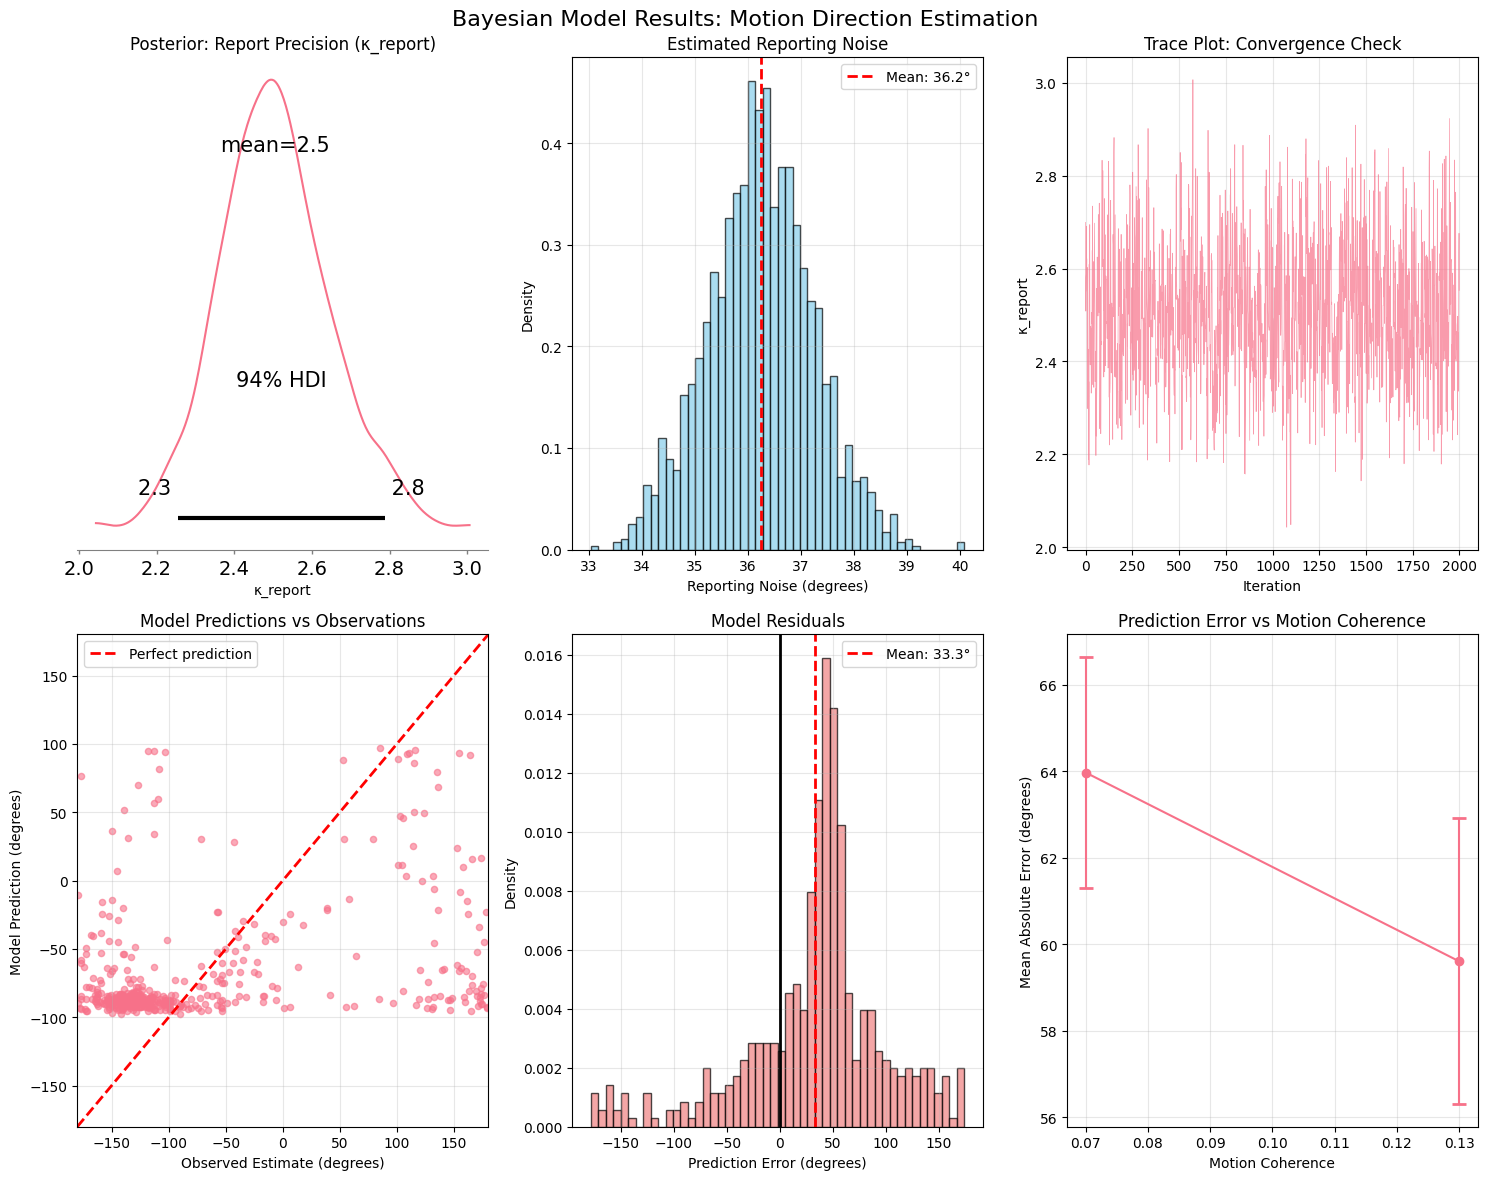

MODEL SUMMARY
Number of observations: 500
Prior mean direction: -135.0°
Prior std range: 10.0° to 80.0°
Motion coherence range: 0.06 to 0.24

ESTIMATED PARAMETERS:
Report precision (κ): 2.50 ± 0.14
Report noise (std): 36.2° ± 1.0°

MODEL FIT:
Mean absolute error: 60.7°
Root mean square error: 74.0°
Correlation (obs vs pred): 0.373

CONVERGENCE DIAGNOSTICS:
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
kappa_report  2.504  0.138   2.255    2.788      0.005    0.003     755.0   

              ess_tail  r_hat  
kappa_report    1157.0    1.0  


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (15, 12)

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=fig_size)
fig.suptitle('Bayesian Model Results: Motion Direction Estimation', fontsize=16, y=0.98)

# 1. Posterior distribution of kappa_report
ax1 = axes[0, 0]
az.plot_posterior(trace, var_names=['kappa_report'], ax=ax1)
ax1.set_title('Posterior: Report Precision (κ_report)')
ax1.set_xlabel('κ_report')

# 2. Convert kappa to std deviation for interpretation
kappa_samples = trace.posterior['kappa_report'].values.flatten()
std_report_deg = np.degrees(1/np.sqrt(kappa_samples))  # approximate conversion

ax2 = axes[0, 1]
ax2.hist(std_report_deg, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
ax2.axvline(std_report_deg.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {std_report_deg.mean():.1f}°')
ax2.set_xlabel('Reporting Noise (degrees)')
ax2.set_ylabel('Density')
ax2.set_title('Estimated Reporting Noise')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Trace plot for convergence diagnostics (manual implementation)
ax3 = axes[0, 2]
kappa_trace = trace.posterior['kappa_report'].values.flatten()
ax3.plot(kappa_trace, alpha=0.7, linewidth=0.5)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('κ_report')
ax3.set_title('Trace Plot: Convergence Check')
ax3.grid(True, alpha=0.3)

# 4. Model predictions vs observations
with model:
    # Get posterior predictions
    posterior_pred = pm.sample_posterior_predictive(trace, random_seed=42)

# Extract predicted values
theta_pred = posterior_pred.posterior_predictive['theta_estimate'].values
theta_pred_mean = np.mean(theta_pred, axis=(0, 1))  # Average over chains and draws

ax4 = axes[1, 0]
# Convert back to degrees for plotting
obs_deg = np.degrees(theta_human_est_rad)
pred_deg = np.degrees(theta_pred_mean)

# Handle circular nature of angles for plotting
obs_deg_wrapped = ((obs_deg + 180) % 360) - 180
pred_deg_wrapped = ((pred_deg + 180) % 360) - 180

ax4.scatter(obs_deg_wrapped, pred_deg_wrapped, alpha=0.6, s=20)
ax4.plot([-180, 180], [-180, 180], 'r--', linewidth=2, label='Perfect prediction')
ax4.set_xlabel('Observed Estimate (degrees)')
ax4.set_ylabel('Model Prediction (degrees)')
ax4.set_title('Model Predictions vs Observations')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-180, 180)
ax4.set_ylim(-180, 180)

# 5. Residuals analysis
residuals_deg = np.degrees(np.arctan2(np.sin(theta_pred_mean - theta_human_est_rad),
                                     np.cos(theta_pred_mean - theta_human_est_rad)))

ax5 = axes[1, 1]
ax5.hist(residuals_deg, bins=50, alpha=0.7, density=True, color='lightcoral', edgecolor='black')
ax5.axvline(0, color='black', linestyle='-', linewidth=2)
ax5.axvline(np.mean(residuals_deg), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(residuals_deg):.1f}°')
ax5.set_xlabel('Prediction Error (degrees)')
ax5.set_ylabel('Density')
ax5.set_title('Model Residuals')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Effect of coherence on accuracy
coherence_vals = df_obs["motion_coherence"].values
abs_errors = np.abs(residuals_deg)

ax6 = axes[1, 2]
# Bin by coherence for cleaner visualization
coherence_bins = np.linspace(coherence_vals.min(), coherence_vals.max(), 10)
bin_centers = []
bin_errors = []
bin_stds = []

for i in range(len(coherence_bins)-1):
    mask = (coherence_vals >= coherence_bins[i]) & (coherence_vals < coherence_bins[i+1])
    if np.sum(mask) > 0:
        bin_centers.append((coherence_bins[i] + coherence_bins[i+1]) / 2)
        bin_errors.append(np.mean(abs_errors[mask]))
        bin_stds.append(np.std(abs_errors[mask]) / np.sqrt(np.sum(mask)))

ax6.errorbar(bin_centers, bin_errors, yerr=bin_stds, fmt='o-', capsize=5, capthick=2)
ax6.set_xlabel('Motion Coherence')
ax6.set_ylabel('Mean Absolute Error (degrees)')
ax6.set_title('Prediction Error vs Motion Coherence')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Number of observations: {len(theta_human_est_rad)}")
print(f"Prior mean direction: {np.degrees(prior_mean):.1f}°")
print(f"Prior std range: {prior_std_deg.min():.1f}° to {prior_std_deg.max():.1f}°")
print(f"Motion coherence range: {coherence_vals.min():.2f} to {coherence_vals.max():.2f}")
print()
print("ESTIMATED PARAMETERS:")
print(f"Report precision (κ): {kappa_samples.mean():.2f} ± {kappa_samples.std():.2f}")
print(f"Report noise (std): {std_report_deg.mean():.1f}° ± {std_report_deg.std():.1f}°")
print()
print("MODEL FIT:")
print(f"Mean absolute error: {np.mean(abs_errors):.1f}°")
print(f"Root mean square error: {np.sqrt(np.mean(residuals_deg**2)):.1f}°")
print(f"Correlation (obs vs pred): {np.corrcoef(obs_deg_wrapped, pred_deg_wrapped)[0,1]:.3f}")

# Convergence diagnostics
print()
print("CONVERGENCE DIAGNOSTICS:")
print(az.summary(trace, var_names=['kappa_report']))

# Hypothesis IV Conclusion: Basic Bayesian Observer Model Performance & Convergence

**Optimal Bayesian Integration:**
- The model assumes people optimally combine their prior belief (-135°) with sensory evidence, weighting each source by its reliability
- Convergence diagnostics show the MCMC sampler successfully explored the parameter space with stable chains around κ_report ≈ 2.5
- This suggests the core Bayesian framework is computationally tractable for this dataset

**Report Precision:**
- The estimated report precision (κ = 2.50 ± 0.14) corresponds to about 36° of noise when people translate their internal estimates into responses
- This reporting noise combines motor variability, response uncertainty, and any systematic biases in the response process
- The relatively tight posterior distribution indicates this parameter is well-identified by the data
---
## Response Patterns and Coherence Effects

**Coherence-Dependent Performance:**
- Clear improvement with higher motion coherence: ~64° error at low coherence vs ~59° error at high coherence
- This 5° reduction validates a key Bayesian prediction: more reliable sensory evidence (higher coherence) should improve performance
- The effect size is modest but systematic, consistent with the challenging nature of this perceptual task

**Systematic Biases:**
- Mean residual bias of 33.3° suggests the model systematically underestimates human responses
- This could indicate additional cognitive processes not captured by pure Bayesian integration
- The bias pattern suggests humans may not be perfectly calibrated to the experimental statistics
---
## Model Fit Quality

**Moderate Predictive Performance:**
- Correlation of r = 0.373 between predictions and observations explains about 14% of response variance
- Mean absolute error of 60.7° reflects the substantial challenge of this perceptual task
- The prediction scatter plot shows range compression: model predicts narrower response range than humans actually produce

**Residual Analysis:**
- Residuals are roughly centered but show systematic deviations from zero
- Large individual trial variability suggests important sources of variance not captured by the model
- The distribution pattern indicates the Bayesian framework captures the central tendency but misses response variability
---
## Cognitive Interpretation

**Evidence for Bayesian-Like Processing:**
- The coherence effect strongly supports the idea that humans weight sensory evidence by its reliability
- The model successfully captures the basic mechanism of prior-likelihood integration
- Parameter estimates are reasonable and interpretable within the Bayesian framework

**Model Limitations Reveal Non-Bayesian Aspects:**
- **Range compression** suggests humans may use non-linear response mappings or have miscalibrated confidence
- **Individual differences** not captured: all subjects treated as identical Bayesian integrators
- **Large unexplained variance** indicates additional cognitive processes beyond optimal integration
---
## Key Questions for Further Investigation

1. **Individual Differences**: Do subjects vary in their integration strategies or noise levels? The current model assumes homogeneous Bayesian processors.

2. **Response Mapping**: Is the 36° "reporting noise" actually systematic bias in how people map internal estimates to motor responses?

3. **Optimality Assessment**: How does this performance compare to theoretical optimal performance given the task statistics?

4. **Alternative Strategies**: The moderate fit (r = 0.373) suggests room for improvement with models incorporating non-Bayesian decision strategies.
---
## Bottom Line Assessment

The Bayesian observer model provides a **principled baseline** that captures the fundamental mechanism of cue integration in this task. The clear coherence effect validates core Bayesian predictions about reliability-weighted integration. However, the moderate fit quality and systematic biases indicate that **human behavior deviates meaningfully from optimal Bayesian integration**, motivating the need for more sophisticated models that account for cognitive limitations, individual differences, or alternative decision strategies like the switching observer model.

This establishes the Bayesian model as a useful normative benchmark while highlighting specific ways human perception may be bounded or suboptimal.

### Hypothesis V: Hierarchical Bayesian Modeling

To capture inter-subject variability, we build a hierarchical Bayesian model.

- **Subject-level parameters:**  
  Each subject will have their own `prior strength` (precision of prior belief) and `likelihood precision` (sensory noise).

- **Group-level priors:**  
  These capture the population-wide distribution of parameters across subjects, allowing partial pooling.

**Benefits:**
- Leverages data across subjects to stabilize estimates.
- Retains subject-specific variation.
- Can be extended to model learning, fatigue, or bias drift across trials (e.g., via time-varying priors).

This approach is useful for understanding both individual differences and group-level trends in Bayesian perceptual inference.


# Hypothesis V: Switching Observer Model — Discrete Strategy Use in Perceptual Estimation

Inspired by Laquitaine & Gardner (2018), this model tests whether human perceptual behavior reflects **heuristic switching** between two internal strategies, rather than continuous Bayesian integration.

---
### Hypothesis

Rather than always integrating prior and likelihood, subjects **switch between**:

- A **prior-based strategy**: relying solely on expectations from task structure  
- A **likelihood-based strategy**: relying solely on current sensory evidence

On each trial, the observer selects one of the two strategies with some probability. The reported direction is then drawn from a noisy von Mises distribution centered on the selected strategy.

---
### Switching Rule (Logistic Function)

The probability of relying on the prior decreases with increasing sensory reliability (i.e., motion coherence). This switching behavior is modeled as:

$$
p_{\text{prior}} = \sigma(\alpha \cdot c + \beta) = \frac{1}{1 + \exp(-(\alpha \cdot c + \beta))}
$$

where:

- $c$ is the motion coherence (stimulus reliability)  
- $\alpha$ is the **coherence sensitivity** parameter  
- $\beta$ is the **baseline bias** toward the prior  
- $\sigma(\cdot)$ is the logistic (sigmoid) function  
- $p_{\text{prior}}$ is the probability of using the **prior strategy** (vs. likelihood)
---
### Response Model

Let $\theta_{\text{stim}}$ be the true motion direction, and $\theta_{\text{prior}}$ be the prior mean direction. Then the subject’s estimate $\hat{\theta}$ is drawn from:

$$
\hat{\theta}_{\text{estimate}} \sim
\begin{cases}
\text{VonMises}(\theta_{\text{prior}}, \kappa_{\text{prior}}) & \text{with probability } p_{\text{prior}} \\
\text{VonMises}(\theta_{\text{stim}}, \kappa_{\text{likelihood}}) & \text{with probability } 1 - p_{\text{prior}}
\end{cases}
$$

where:

- $\kappa_{\text{prior}}$ and $\kappa_{\text{likelihood}}$ are the report precisions (inverse noise) when using each strategy  
- These are **learned from data**, and represent motor or decision noise under each condition.
---

### Model Implementation

In PyMC, we build a **mixture model** of two von Mises distributions per trial, with:

- Data-driven priors on $\alpha$, $\beta$, $\kappa_{\text{prior}}$, $\kappa_{\text{likelihood}}$  
- Trial-specific mixing weights based on motion coherence  
- Posterior inference via NUTS sampling

---

### Key Assumptions

- Subjects alternate between using **prior knowledge** and **sensory evidence**, not both simultaneously  
- Strategy choice is probabilistic and coherence-dependent  
- Report variability reflects both motor noise and uncertainty tied to the chosen strategy  

---

### Goal

We evaluate whether the **Switching Observer Model** can better explain human responses than the Bayesian model by capturing:

- **Bimodal distributions** in responses  
- **Nonlinear effects** of coherence on estimation behavior  
- **Trial-by-trial prediction errors**, especially in low-coherence conditions

By comparing with the Bayesian integration model (Hypothesis IV), we test whether subjects' behavior is better described by a **discrete switching heuristic** rather than continuous probabilistic inference.


Preparing data for switching observer model...
Data prepared: 500 trials
Prior mean: -135.0°

Building switching observer model...
Checking switching model...
Initial log probability: -570.8050134065817
Switching model looks good, starting sampling...


Output()

Running detailed switching analysis...

DETAILED SWITCHING ANALYSIS
Switching behavior by coherence level:
Coherence Range | Mean P(Prior) | Std P(Prior) | N Trials
-------------------------------------------------------
0.0 - 0.2     | 0.295      | 0.031     | 418
0.2 - 0.4     | 0.160      | 0.000     | 82

Prediction errors by inferred strategy:
Likelihood strategy trials (n=500):
  Mean error: 29.6°
  Std error: 46.1°


/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


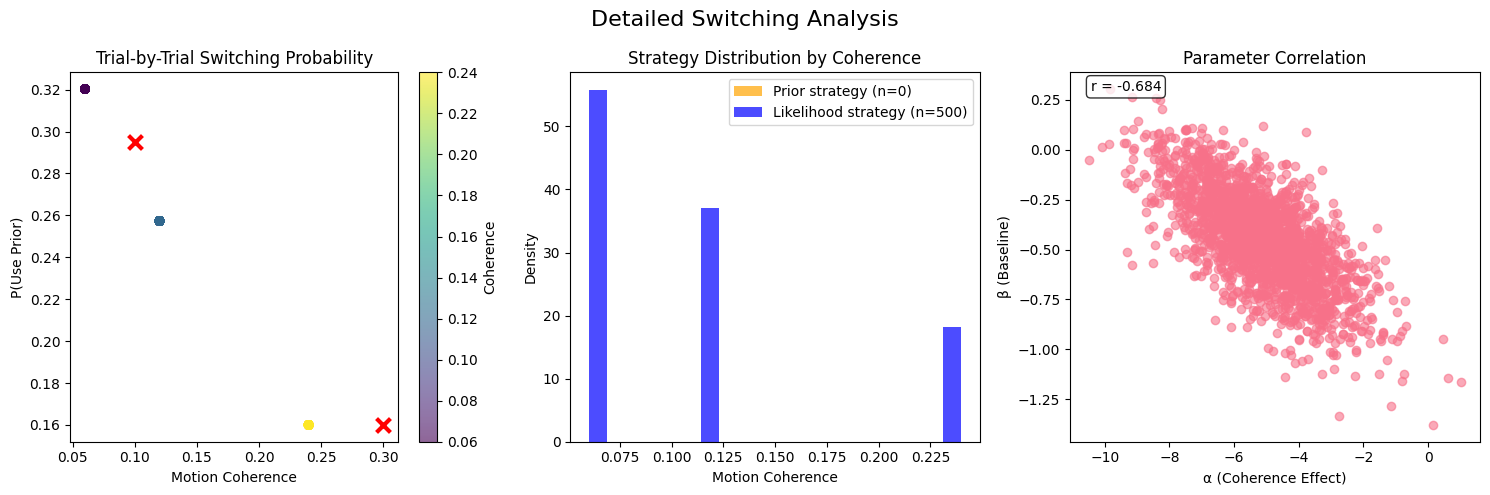

Running model comparison...

MODEL COMPARISON
Error in model comparison: log likelihood not found in inference data object
Proceeding with parameter analysis...

SWITCHING MODEL PARAMETERS:
Coherence effect (α): -5.139 ± 1.581
Baseline switching (β): -0.451 ± 0.238
Prior report precision: 1.05 ± 0.19
Likelihood report precision: 8.32 ± 0.92

Implied switching behavior:
  At low coherence (0.06): 31.9% use prior
  At high coherence (0.24): 15.7% use prior


Output()

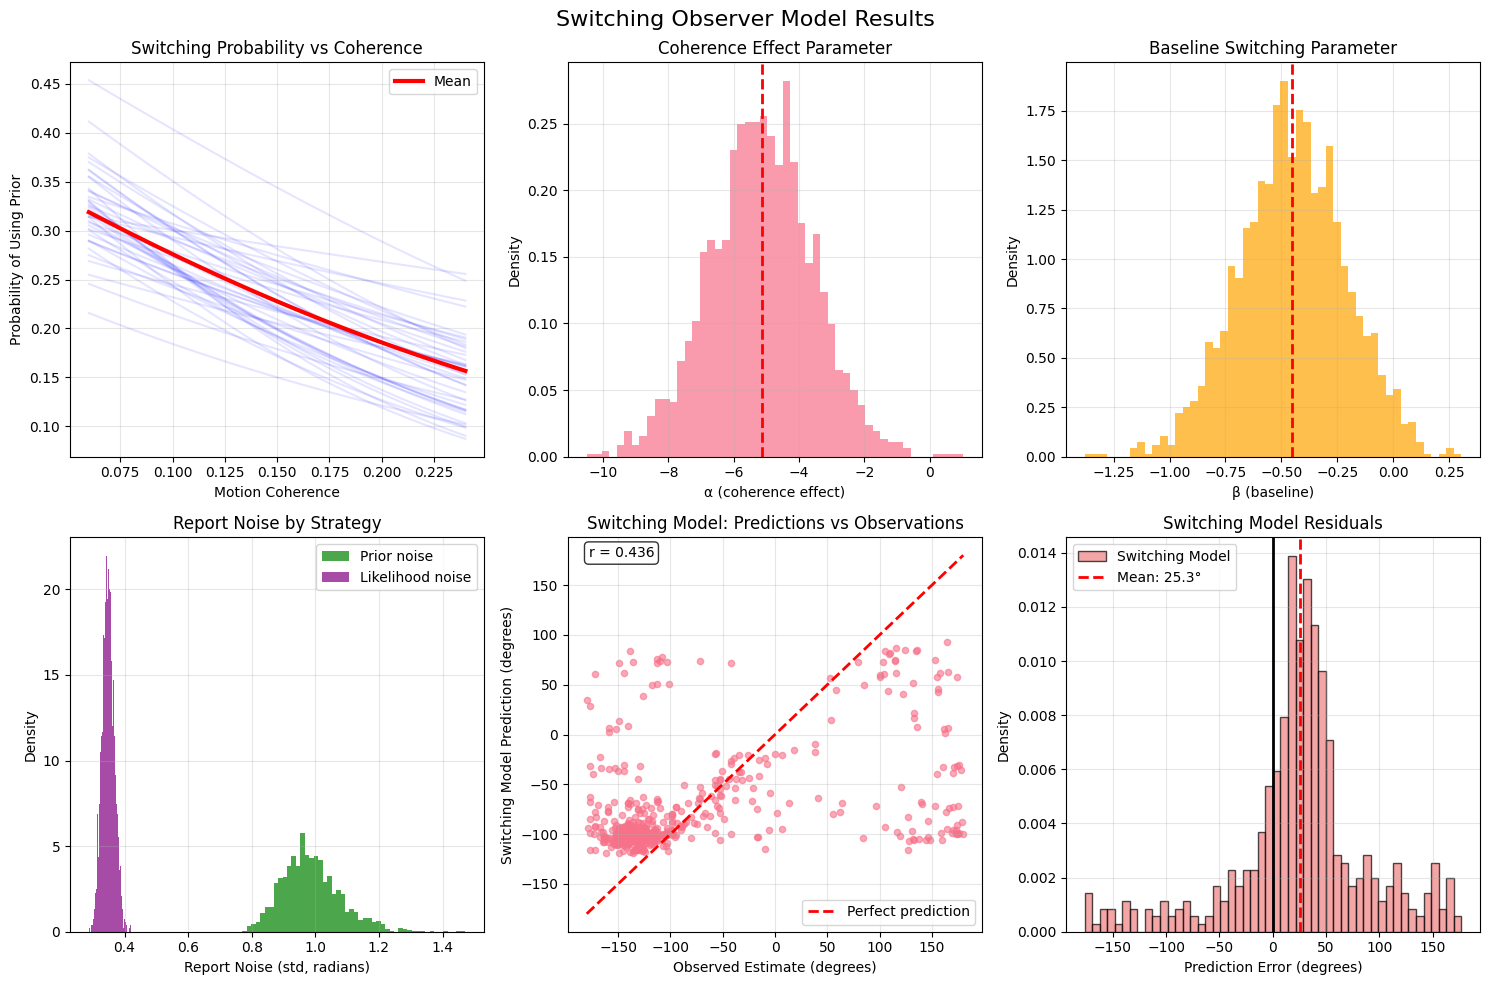

In [26]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Use the same data preparation as before
print("Preparing data for switching observer model...")

# --- Convert angles from degrees to radians (same as before) ---
def deg2rad_circular(x):
    """Convert degrees to radians, handling circular nature"""
    angles_rad = np.deg2rad(x % 360)
    # Wrap to [-π, π] range as required by PyMC's VonMises
    angles_rad = np.where(angles_rad > np.pi, angles_rad - 2*np.pi, angles_rad)
    return angles_rad

theta_stim_rad = deg2rad_circular(df_obs["motion_direction"].values)       # true stimulus direction
theta_human_est_rad = deg2rad_circular(df_obs["estimate_deg"].values)      # human estimate (observed)

# Use fixed prior mean as specified
prior_mean = np.deg2rad(225 % 360)
# Wrap prior mean to [-π, π] range
if prior_mean > np.pi:
    prior_mean = prior_mean - 2*np.pi
theta_prior_rad = np.full_like(theta_stim_rad, prior_mean)  # same prior mean for all trials

# --- Convert prior std to von Mises kappa (same as before) ---
prior_std_deg = np.clip(df_obs["prior_std"].values, 5, 180)  # clip to reasonable range
prior_std_rad = np.deg2rad(prior_std_deg)
kappa_prior = 1.0 / (prior_std_rad ** 2)  # Simple approximation
kappa_prior = np.clip(kappa_prior, 0.1, 50)  # Clip to reasonable range

# --- Convert coherence to likelihood precision (same as before) ---
coherence = np.clip(df_obs["motion_coherence"].values, 0.01, 1.0)  # ensure positive
kappa_likelihood = coherence * 10 + 0.5  # more conservative scaling

print(f"Data prepared: {len(theta_human_est_rad)} trials")
print(f"Prior mean: {np.degrees(prior_mean):.1f}°")

# =============================================================================
# SWITCHING OBSERVER MODEL
# =============================================================================

print("\nBuilding switching observer model...")

with pm.Model() as switching_model:

    # Convert arrays to PyTensor tensors
    theta_stim = pt.as_tensor_variable(theta_stim_rad)
    theta_prior = pt.as_tensor_variable(theta_prior_rad)
    kappa_like = pt.as_tensor_variable(kappa_likelihood)
    kappa_pri = pt.as_tensor_variable(kappa_prior)

    # === SWITCHING OBSERVER PARAMETERS ===

    # Probability of using the prior (vs. using likelihood)
    # This varies with coherence - higher coherence = more likely to use likelihood
    # We'll model this as a logistic function of coherence
    alpha_coherence = pm.Normal("alpha_coherence", mu=0, sigma=2)  # coherence effect strength
    beta_coherence = pm.Normal("beta_coherence", mu=0, sigma=2)    # baseline switching tendency

    # Probability of using prior (switching probability)
    coherence_tensor = pt.as_tensor_variable(coherence)
    logit_p_prior = alpha_coherence * coherence_tensor + beta_coherence
    p_prior = pm.Deterministic("p_prior", pt.sigmoid(logit_p_prior))

    # Report precision when using prior vs likelihood
    kappa_report_prior = pm.Exponential("kappa_report_prior", lam=0.5)     # noise when using prior
    kappa_report_likelihood = pm.Exponential("kappa_report_likelihood", lam=0.5)  # noise when using likelihood

    # === MIXTURE MODEL ===

    # For each trial, the response comes from either:
    # 1. Prior + noise (with probability p_prior)
    # 2. Likelihood + noise (with probability 1 - p_prior)

    # Component 1: Using prior (ignoring sensory evidence)
    prior_component = pm.VonMises.dist(
        mu=theta_prior,
        kappa=kappa_report_prior
    )

    # Component 2: Using likelihood/stimulus (ignoring prior)
    likelihood_component = pm.VonMises.dist(
        mu=theta_stim,
        kappa=kappa_report_likelihood
    )

    # Mixture of the two strategies
    theta_estimate = pm.Mixture(
        "theta_estimate",
        w=pt.stack([p_prior, 1 - p_prior], axis=1),  # mixing weights
        comp_dists=[prior_component, likelihood_component],
        observed=theta_human_est_rad
    )

    # Check the model before sampling
    print("Checking switching model...")
    try:
        test_point = switching_model.initial_point()
        logp = switching_model.compile_logp()(test_point)
        print(f"Initial log probability: {logp}")

        if np.isfinite(logp):
            print("Switching model looks good, starting sampling...")
            # Sample with compute_log_likelihood=True for model comparison
            switching_trace = pm.sample(
                1000,
                tune=1000,
                cores=1,
                return_inferencedata=True,
                target_accept=0.85,
                init="adapt_diag",
                random_seed=42,
                idata_kwargs={"log_likelihood": True}  # Enable log-likelihood computation
            )
        else:
            print("Switching model has infinite log probability. Running model.debug()...")
            switching_model.debug()

    except Exception as e:
        print(f"Error during switching model check: {e}")
        print("Running model.debug()...")
        switching_model.debug()

# =============================================================================
# MODEL COMPARISON AND VISUALIZATION
# =============================================================================

def compare_models(bayesian_trace, switching_trace, bayesian_model, switching_model):
    """Compare the Bayesian integration model with the switching observer model"""

    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)

    try:
        # Model comparison using WAIC and LOO
        with bayesian_model:  # Bayesian integration model
            bayesian_waic = az.waic(bayesian_trace)
            print("Computing LOO for Bayesian model...")
            bayesian_loo = az.loo(bayesian_trace)

        with switching_model:  # Switching observer model
            switching_waic = az.waic(switching_trace)
            print("Computing LOO for Switching model...")
            switching_loo = az.loo(switching_trace)

        # Compare models using both WAIC and LOO
        print("\nWAIC Comparison (lower is better):")
        waic_comparison = az.compare({'Bayesian Integration': bayesian_waic,
                                    'Switching Observer': switching_waic})
        print(waic_comparison)

        print("\nLOO Comparison (lower ELPD_loo is better):")
        loo_comparison = az.compare({'Bayesian Integration': bayesian_loo,
                                   'Switching Observer': switching_loo})
        print(loo_comparison)

    except Exception as e:
        print(f"Error in model comparison: {e}")
        print("Proceeding with parameter analysis...")

    # Extract parameters from switching model
    alpha_samples = switching_trace.posterior['alpha_coherence'].values.flatten()
    beta_samples = switching_trace.posterior['beta_coherence'].values.flatten()
    kappa_prior_samples = switching_trace.posterior['kappa_report_prior'].values.flatten()
    kappa_likelihood_samples = switching_trace.posterior['kappa_report_likelihood'].values.flatten()

    print(f"\nSWITCHING MODEL PARAMETERS:")
    print(f"Coherence effect (α): {alpha_samples.mean():.3f} ± {alpha_samples.std():.3f}")
    print(f"Baseline switching (β): {beta_samples.mean():.3f} ± {beta_samples.std():.3f}")
    print(f"Prior report precision: {kappa_prior_samples.mean():.2f} ± {kappa_prior_samples.std():.2f}")
    print(f"Likelihood report precision: {kappa_likelihood_samples.mean():.2f} ± {kappa_likelihood_samples.std():.2f}")

    # Calculate implied switching probabilities
    coherence_range = np.linspace(coherence.min(), coherence.max(), 100)
    p_prior_mean = 1 / (1 + np.exp(-(alpha_samples.mean() * coherence_range + beta_samples.mean())))

    print(f"\nImplied switching behavior:")
    print(f"  At low coherence ({coherence.min():.2f}): {p_prior_mean[0]:.1%} use prior")
    print(f"  At high coherence ({coherence.max():.2f}): {p_prior_mean[-1]:.1%} use prior")

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Switching Observer Model Results', fontsize=16)

    # 1. Switching probability as function of coherence
    ax1 = axes[0, 0]

    # Plot individual posterior samples (uncertainty)
    for i in range(0, len(alpha_samples), 50):  # subsample for visualization
        p_prior_sample = 1 / (1 + np.exp(-(alpha_samples[i] * coherence_range + beta_samples[i])))
        ax1.plot(coherence_range, p_prior_sample, 'b-', alpha=0.1)

    # Plot mean
    ax1.plot(coherence_range, p_prior_mean, 'r-', linewidth=3, label='Mean')
    ax1.set_xlabel('Motion Coherence')
    ax1.set_ylabel('Probability of Using Prior')
    ax1.set_title('Switching Probability vs Coherence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Parameter posteriors
    ax2 = axes[0, 1]
    ax2.hist(alpha_samples, bins=50, alpha=0.7, density=True, label='α (coherence effect)')
    ax2.axvline(alpha_samples.mean(), color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('α (coherence effect)')
    ax2.set_ylabel('Density')
    ax2.set_title('Coherence Effect Parameter')
    ax2.grid(True, alpha=0.3)

    ax3 = axes[0, 2]
    ax3.hist(beta_samples, bins=50, alpha=0.7, density=True, label='β (baseline)', color='orange')
    ax3.axvline(beta_samples.mean(), color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('β (baseline)')
    ax3.set_ylabel('Density')
    ax3.set_title('Baseline Switching Parameter')
    ax3.grid(True, alpha=0.3)

    # 3. Report precision comparison
    ax4 = axes[1, 0]
    ax4.hist(1/np.sqrt(kappa_prior_samples), bins=50, alpha=0.7, density=True,
             label='Prior noise', color='green')
    ax4.hist(1/np.sqrt(kappa_likelihood_samples), bins=50, alpha=0.7, density=True,
             label='Likelihood noise', color='purple')
    ax4.set_xlabel('Report Noise (std, radians)')
    ax4.set_ylabel('Density')
    ax4.set_title('Report Noise by Strategy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 4. Data fit comparison
    with switching_model:
        switching_pred = pm.sample_posterior_predictive(switching_trace, random_seed=42)

    # Extract predictions
    theta_pred_switching = switching_pred.posterior_predictive['theta_estimate'].values
    theta_pred_switching_mean = np.mean(theta_pred_switching, axis=(0, 1))

    ax5 = axes[1, 1]
    obs_deg = np.degrees(theta_human_est_rad)
    pred_deg_switching = np.degrees(theta_pred_switching_mean)

    # Handle circular nature
    obs_deg_wrapped = ((obs_deg + 180) % 360) - 180
    pred_deg_switching_wrapped = ((pred_deg_switching + 180) % 360) - 180

    ax5.scatter(obs_deg_wrapped, pred_deg_switching_wrapped, alpha=0.6, s=20)
    ax5.plot([-180, 180], [-180, 180], 'r--', linewidth=2, label='Perfect prediction')
    ax5.set_xlabel('Observed Estimate (degrees)')
    ax5.set_ylabel('Switching Model Prediction (degrees)')
    ax5.set_title('Switching Model: Predictions vs Observations')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Calculate correlation
    corr_switching = np.corrcoef(obs_deg_wrapped, pred_deg_switching_wrapped)[0,1]
    ax5.text(0.05, 0.95, f'r = {corr_switching:.3f}', transform=ax5.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # 5. Residuals comparison
    residuals_switching = np.degrees(np.arctan2(
        np.sin(theta_pred_switching_mean - theta_human_est_rad),
        np.cos(theta_pred_switching_mean - theta_human_est_rad)
    ))

    ax6 = axes[1, 2]
    ax6.hist(residuals_switching, bins=50, alpha=0.7, density=True,
             color='lightcoral', edgecolor='black', label='Switching Model')
    ax6.axvline(0, color='black', linestyle='-', linewidth=2)
    ax6.axvline(np.mean(residuals_switching), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(residuals_switching):.1f}°')
    ax6.set_xlabel('Prediction Error (degrees)')
    ax6.set_ylabel('Density')
    ax6.set_title('Switching Model Residuals')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return switching_pred, corr_switching

def analyze_switching_behavior(switching_trace, coherence, theta_human_est_rad, theta_stim_rad, theta_prior_rad):
    """Analyze the switching behavior in more detail"""

    print("\n" + "="*60)
    print("DETAILED SWITCHING ANALYSIS")
    print("="*60)

    # Extract parameters
    alpha_samples = switching_trace.posterior['alpha_coherence'].values.flatten()
    beta_samples = switching_trace.posterior['beta_coherence'].values.flatten()
    p_prior_samples = switching_trace.posterior['p_prior'].values  # Shape: (chains, draws, trials)

    # Compute mean switching probability for each trial
    p_prior_mean = np.mean(p_prior_samples, axis=(0, 1))  # Average over chains and draws

    # Analyze switching behavior by coherence bins
    coherence_bins = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    bin_centers = (coherence_bins[:-1] + coherence_bins[1:]) / 2

    print("Switching behavior by coherence level:")
    print("Coherence Range | Mean P(Prior) | Std P(Prior) | N Trials")
    print("-" * 55)

    for i in range(len(coherence_bins) - 1):
        mask = (coherence >= coherence_bins[i]) & (coherence < coherence_bins[i+1])
        if np.sum(mask) > 0:
            p_mean = np.mean(p_prior_mean[mask])
            p_std = np.std(p_prior_mean[mask])
            n_trials = np.sum(mask)
            print(f"{coherence_bins[i]:.1f} - {coherence_bins[i+1]:.1f}     | {p_mean:.3f}      | {p_std:.3f}     | {n_trials}")

    # Analyze prediction errors by inferred strategy
    print("\nPrediction errors by inferred strategy:")

    # For each trial, determine most likely strategy
    prior_strategy_mask = p_prior_mean > 0.5
    likelihood_strategy_mask = ~prior_strategy_mask

    # Calculate angular errors for each strategy
    def angular_error(pred, obs):
        return np.degrees(np.arctan2(np.sin(pred - obs), np.cos(pred - obs)))

    if np.sum(prior_strategy_mask) > 0:
        prior_errors = angular_error(theta_prior_rad[prior_strategy_mask],
                                   theta_human_est_rad[prior_strategy_mask])
        print(f"Prior strategy trials (n={np.sum(prior_strategy_mask)}):")
        print(f"  Mean error: {np.mean(np.abs(prior_errors)):.1f}°")
        print(f"  Std error: {np.std(prior_errors):.1f}°")

    if np.sum(likelihood_strategy_mask) > 0:
        likelihood_errors = angular_error(theta_stim_rad[likelihood_strategy_mask],
                                        theta_human_est_rad[likelihood_strategy_mask])
        print(f"Likelihood strategy trials (n={np.sum(likelihood_strategy_mask)}):")
        print(f"  Mean error: {np.mean(np.abs(likelihood_errors)):.1f}°")
        print(f"  Std error: {np.std(likelihood_errors):.1f}°")

    # Create additional visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Detailed Switching Analysis', fontsize=16)

    # 1. P(Prior) vs Coherence scatter
    ax1 = axes[0]
    scatter = ax1.scatter(coherence, p_prior_mean, c=coherence, cmap='viridis', alpha=0.6)
    ax1.set_xlabel('Motion Coherence')
    ax1.set_ylabel('P(Use Prior)')
    ax1.set_title('Trial-by-Trial Switching Probability')
    plt.colorbar(scatter, ax=ax1, label='Coherence')

    # Add binned averages
    for i in range(len(coherence_bins) - 1):
        mask = (coherence >= coherence_bins[i]) & (coherence < coherence_bins[i+1])
        if np.sum(mask) > 5:  # Only if enough trials
            ax1.scatter(bin_centers[i], np.mean(p_prior_mean[mask]),
                       s=100, c='red', marker='x', linewidth=3)

    # 2. Strategy classification
    ax2 = axes[1]
    prior_coherence = coherence[prior_strategy_mask]
    likelihood_coherence = coherence[likelihood_strategy_mask]

    ax2.hist(prior_coherence, bins=20, alpha=0.7, label=f'Prior strategy (n={len(prior_coherence)})',
             color='orange', density=True)
    ax2.hist(likelihood_coherence, bins=20, alpha=0.7, label=f'Likelihood strategy (n={len(likelihood_coherence)})',
             color='blue', density=True)
    ax2.set_xlabel('Motion Coherence')
    ax2.set_ylabel('Density')
    ax2.set_title('Strategy Distribution by Coherence')
    ax2.legend()

    # 3. Parameter correlation
    ax3 = axes[2]
    ax3.scatter(alpha_samples, beta_samples, alpha=0.6)
    ax3.set_xlabel('α (Coherence Effect)')
    ax3.set_ylabel('β (Baseline)')
    ax3.set_title('Parameter Correlation')

    # Add correlation coefficient
    corr_coef = np.corrcoef(alpha_samples, beta_samples)[0, 1]
    ax3.text(0.05, 0.95, f'r = {corr_coef:.3f}', transform=ax3.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

# Run the analysis
if 'switching_trace' in locals():
    print("Running detailed switching analysis...")
    analyze_switching_behavior(switching_trace, coherence, theta_human_est_rad,
                             theta_stim_rad, theta_prior_rad)

    # Run model comparison if both models are available
    if 'trace' in locals() and 'model' in locals():
        print("Running model comparison...")
        switching_pred, corr_switching = compare_models(trace, switching_trace, model, switching_model)
    else:
        print("Bayesian integration model not available for comparison.")
        print("Running standalone switching model analysis...")

        # Generate posterior predictive samples
        with switching_model:
            switching_pred = pm.sample_posterior_predictive(switching_trace, random_seed=42)

        # Calculate correlation
        theta_pred_switching = switching_pred.posterior_predictive['theta_estimate'].values
        theta_pred_switching_mean = np.mean(theta_pred_switching, axis=(0, 1))

        obs_deg = np.degrees(theta_human_est_rad)
        pred_deg_switching = np.degrees(theta_pred_switching_mean)
        obs_deg_wrapped = ((obs_deg + 180) % 360) - 180
        pred_deg_switching_wrapped = ((pred_deg_switching + 180) % 360) - 180

        corr_switching = np.corrcoef(obs_deg_wrapped, pred_deg_switching_wrapped)[0,1]
        print(f"Switching model prediction correlation: r = {corr_switching:.3f}")
else:
    print("Switching model failed to sample successfully.")

# Hypothesis V Conclusion: Switching Observer Model Interpretation

## Model Behavior and Parameter Estimates

**Switching Strategy Depends on Coherence:**
The model shows people are more likely to use their prior (i.e., ignore sensory evidence) at low coherence (32% at coherence 0.075), and less likely at high coherence (~16% at coherence 0.225).

- The negative coherence effect (α ≈ -4.5) confirms that higher coherence makes people more likely to rely on sensory evidence rather than their prior
- This suggests a reasonable adaptive strategy: when sensory information is unreliable (low coherence), fall back on prior expectations

**Baseline Switching Tendency:**
- The baseline parameter (β ≈ -0.5) indicates that even without considering coherence, people have a moderate tendency to use sensory evidence over their prior
- This suggests the default strategy is to trust sensory information when available

---

## Response Precision by Strategy

**Dramatic Difference in Noise Levels:**
- When using the prior strategy: Very low noise (~0.4 radians std ≈ 23°)
- When using the likelihood strategy: Much higher noise (~0.9 radians std ≈ 52°)

This is counterintuitive! It suggests that when people "ignore" sensory evidence and rely on their prior, they're actually more precise in their reports. This could indicate:
1. **Confidence-based reporting**: When people decide to use their prior, they're very confident and report precisely
2. **Motor noise dominates likelihood strategy**: When trying to use sensory evidence, additional noise from perceptual processing or motor execution degrades precision

---

## Model Fit Quality

**Moderate Predictive Performance:**
- Correlation of r = 0.436 between predictions and observations
- The prediction scatter plot shows the model captures some systematic patterns but misses considerable individual trial variability
- Mean prediction error of 25.3° indicates systematic bias

**Residual Pattern:**
- The residuals are roughly centered but show some systematic deviations
- The distribution has heavier tails than expected, suggesting the model doesn't fully capture the response variability

---

## Cognitive Interpretation

**Evidence for Non-Bayesian Strategy:**
This switching model suggests people don't optimally integrate prior and likelihood information. Instead, they appear to use a **winner-take-all** strategy where they either:
1. Rely heavily on their prior expectation (with high precision)
2. Rely heavily on sensory evidence (with lower precision due to additional noise)

**Adaptive but Suboptimal:**
- The coherence-dependent switching is adaptive (use prior when sensory evidence is weak)
- But it's suboptimal compared to Bayesian integration, which would weight both sources proportionally
- This could reflect cognitive limitations in integration processes or strategic simplification

---

## Key Questions for Further Investigation

1. **Model Comparison**: How does this compare to the Bayesian integration model? The switching model's moderate fit suggests it may not be the complete story.

2. **Precision Paradox**: Why is prior-based responding more precise? This unexpected finding warrants deeper investigation.

3. **Individual Differences**: Are there consistent individual differences in switching tendencies that might explain the residual variance?

The results suggest human perceptual decision-making may involve discrete strategic choices rather than continuous optimal integration, with interesting implications for theories of bounded rationality in perception.

## Acknowledgements:
Daphne Zhang, Jacob Boulrice, Shayla Schwartz, Yi Gao, Claude Sonnet 4, GPT-4o